In [2]:
# importing packages and modules
import numpy as np
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from io_utils import *
from utils import *
from plotting_utils import *
from analysis_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm
sns.set_context("talk")

colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']
colorsStates = ['tab:orange','tab:blue','tab:green','tab:purple', 'tab:brown']
# colorsStates = ["#2369BD",'#FAA61A',"tab:red","#A9373B",'#99CC66','#59C3C3','#9593D9']
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [3]:
# Example subject
subject = 'ibl_witten_15'

In [4]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 0
priorDirP = [10,1]
maxiter = 300
splitFolds = 5
D = 4 # number of features
sessStop = None # last session to use in fitting
pTanh = 5 # tanh transformation
signedStimulus = True # signed stimulus contrast
fit_init_states = False # not fitting initial latent

# loading data
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
N = sessInd[-1] # number total trials
presentAll = np.ones((N))
presentTrain, presentTest = split_data(N, sessInd, folds=5, blocks=10, random_state=1)
sess = len(sessInd) - 1


In [5]:
lenSessions = np.zeros((sess))
for s in range(sess):
    lenSessions[s] = sessInd[s+1] - sessInd[s]
avg_session_length = int(np.mean(lenSessions))
print("Average session length is ", avg_session_length)

Average session length is  995


In [6]:
# load test log-likelihoods for different K's and sigma's (partial models - static transition matrix and dynamic weights)
avgtestAccuracy = []
avgTestLl = []
llFolds = np.empty((splitFolds), dtype=object)
accuracyFolds = np.empty((splitFolds), dtype=object)
for K in [1,2,3,4,5]:  
    for fold in range(splitFolds):
        data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        llFolds[fold] = data['testLl']
        accuracyFolds[fold] = data['testAccuracy']
    avgTestLl.append(np.mean(llFolds, axis=0))
    avgtestAccuracy.append(np.mean(accuracyFolds, axis=0))
avgTestLl = [x - avgTestLl[0][0] for x in avgTestLl] # normalizing to standard GLM (sigma=0, K=1)
    

# Figure 2B

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


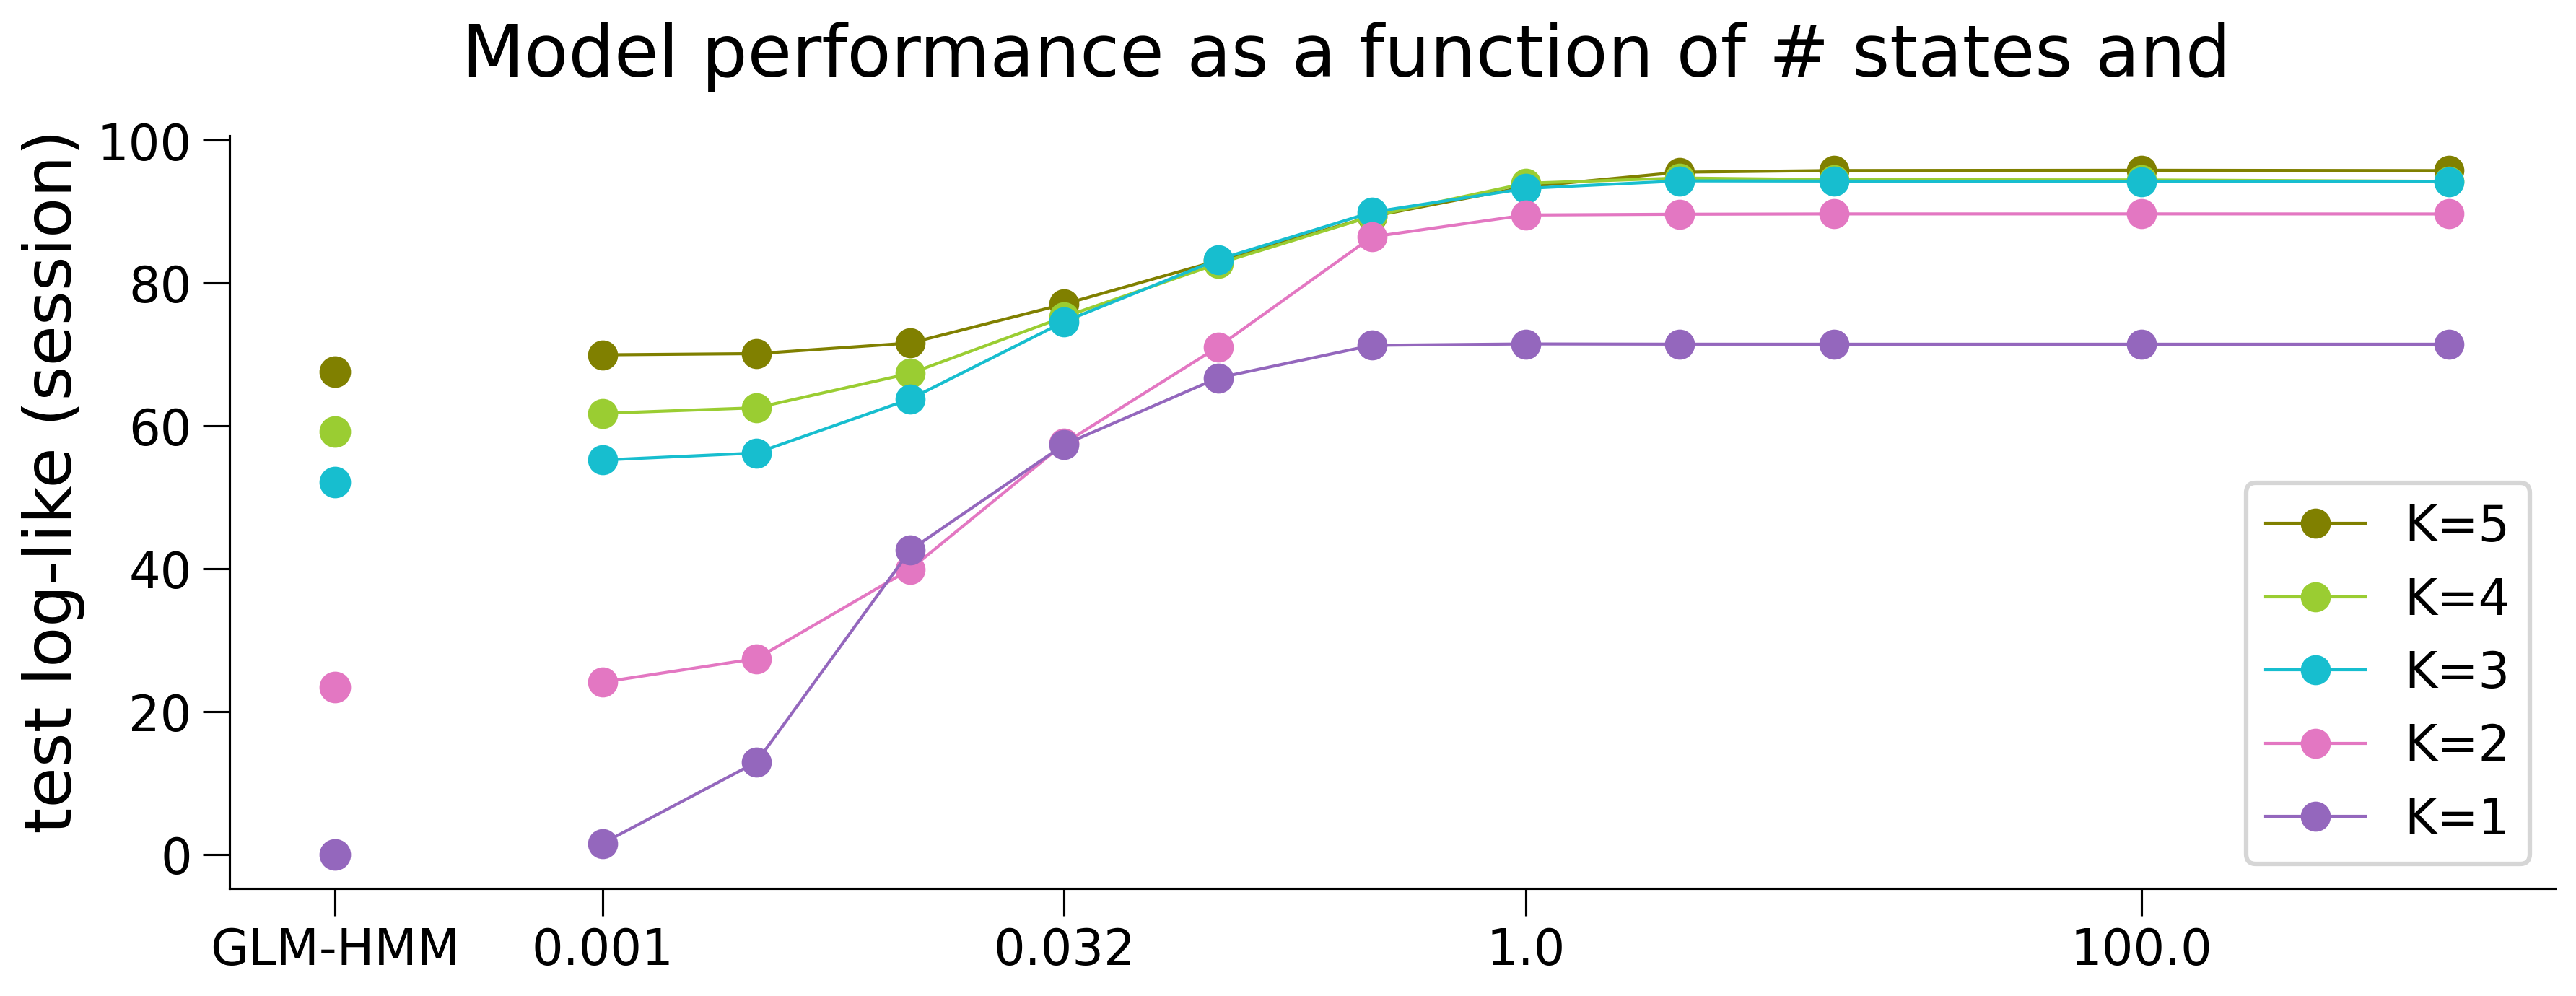

In [7]:
# Plotting delta test log-likelihood averaged across folds as a function of # states and sigma
fig, axes = plt.subplots(1, figsize = (12,4.5), dpi=300)
fig.tight_layout()
for K in range(5,0,-1):#range(5,0,-1):
    plot_testLl_CV_sigma(avgTestLl[K-1] * avg_session_length, sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes, size=24, linewidth=1)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.set_ylabel("   test log-like (session)", size=22)
axes.set_title('Model performance as a function of # states and    ', size=24, pad=20)
axes.set_xlabel('')
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
plt.savefig(f'../figures/TestLl_vs_K_and_sigma_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)

Text(0.5, 33.0, '')

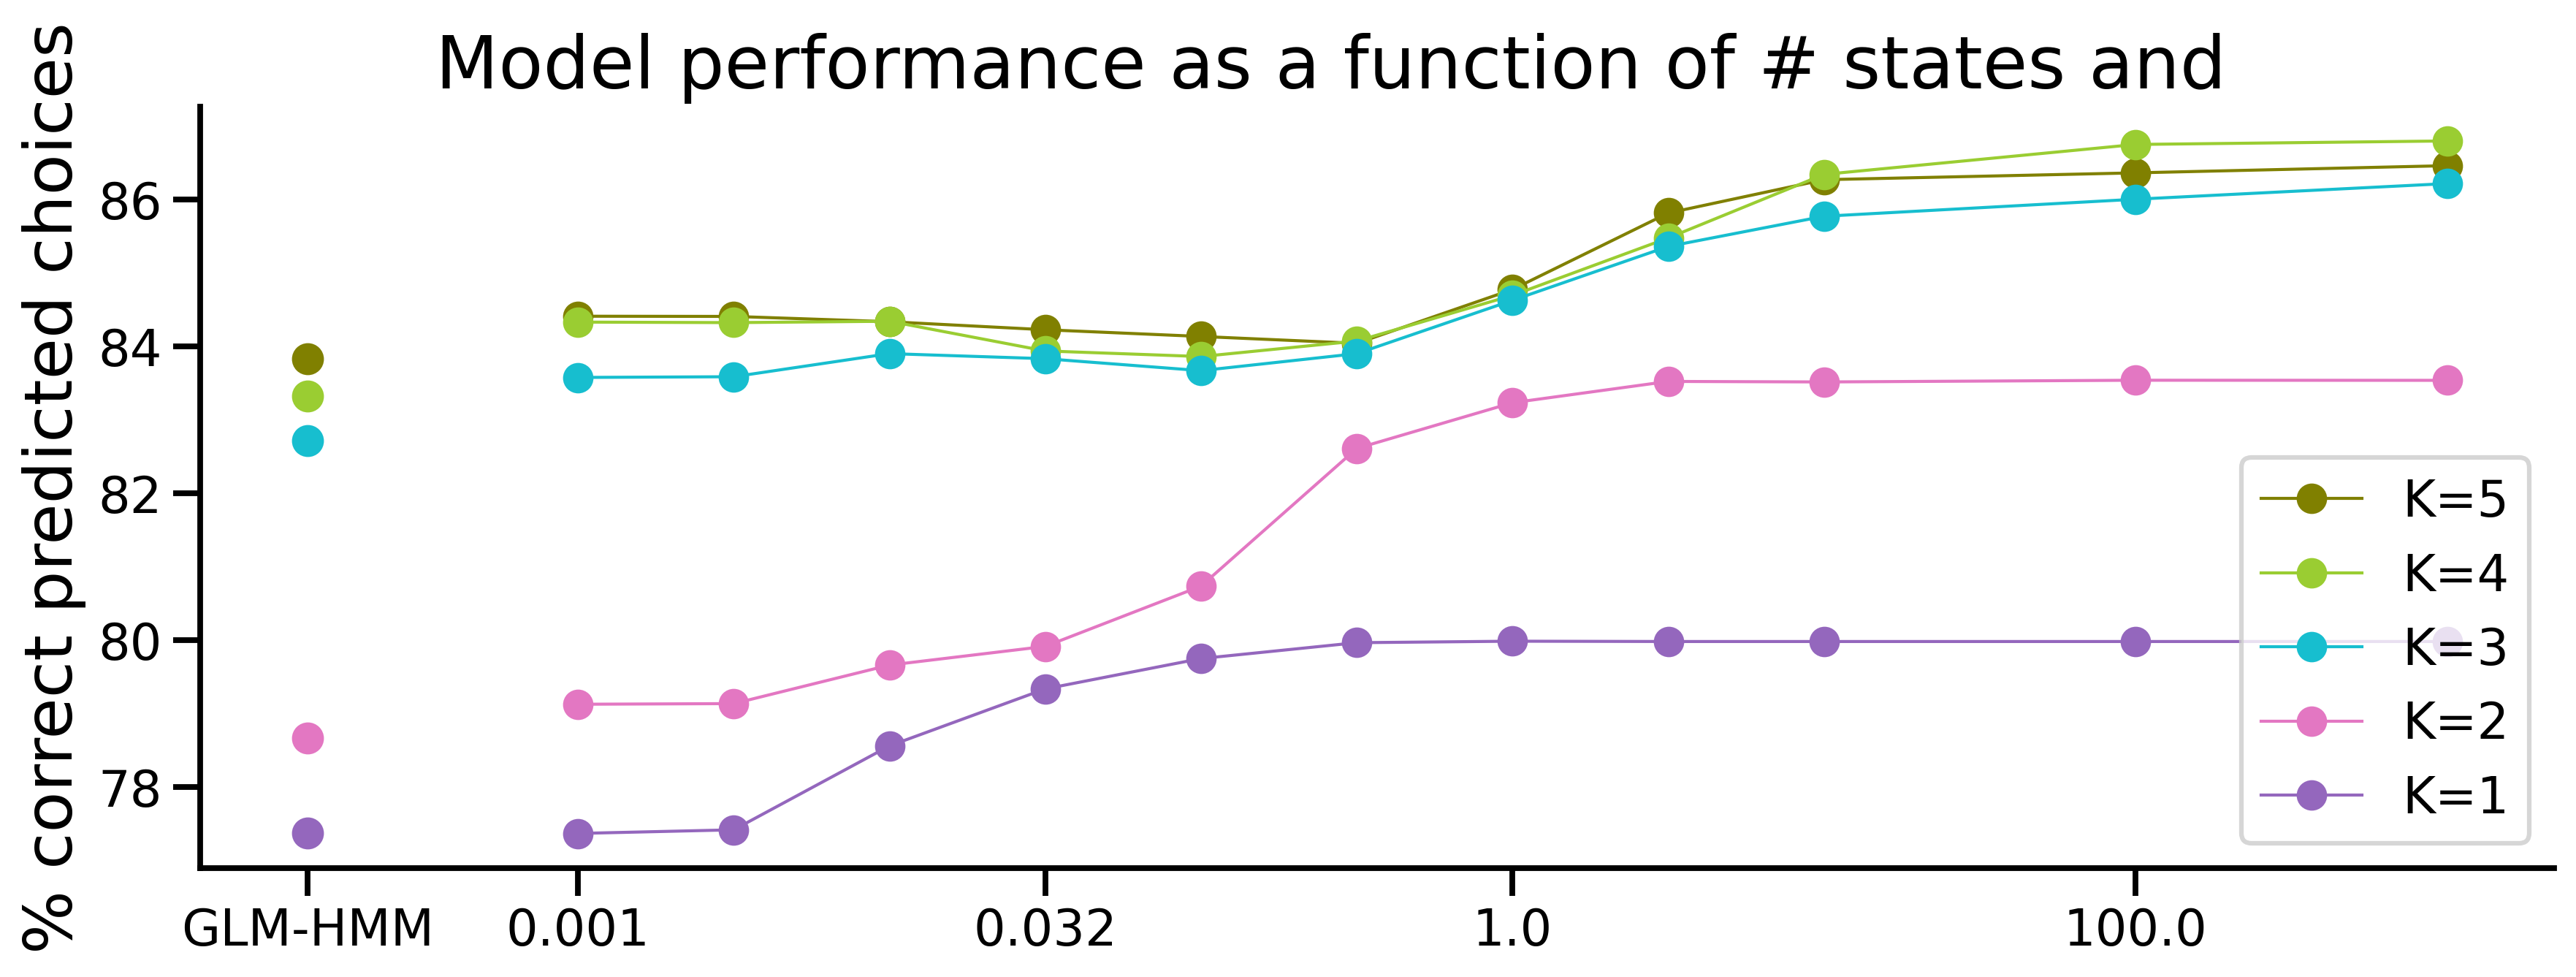

In [8]:
# TO CHECK WHAT IS WRONG

fig, axes = plt.subplots(1, figsize = (12,4.5), dpi=300)
fig.tight_layout()
for K in range(5,0,-1):#range(5,0,-1):
    plot_testLl_CV_sigma(avgtestAccuracy[K-1], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes, size=24)
axes.spines[['right', 'top']].set_visible(False)
axes.set_ylabel("% correct predicted choices", size=22)
axes.set_title('Model performance as a function of # states and    ', size=24)
axes.set_xlabel('')
# plt.savefig(f'../figures/TestLl_vs_K_and_sigma_{subject}.png', bbox_inches='tight', dpi=400)



In [9]:
# load fitted parameters from best partial and dynamic 3-state models
K = 3
pi = np.ones((K)) / K
sessionsInterest = [7,15,30]
bestSigmaInd = 8 # equivalent to sigma=3.16, found by cross-validation, sigma is governing the variability of the weights
bestAlphaInd = 2 # equivalent to alpha=2, found by cross-validation, alpha is governing the variability of the transition matrix
bestAlpha = 2 
plotSess = 45 # number of sessions to plot

tempP1 = np.empty((splitFolds), dtype=object)
tempW1 = np.empty((splitFolds), dtype=object)
tempP = np.empty((splitFolds), dtype=object)
tempW = np.empty((splitFolds), dtype=object)

for fold in range(splitFolds):
    data = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
    tempP[fold] = data['allP']
    tempW[fold] = data['allW']

    data1 = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
    tempP1[fold] = data1['allP']
    tempW1[fold] = data1['allW']

allP_dynamic = np.mean(tempP, axis=0)
allW_dynamic = np.mean(tempW, axis=0) 
allP_partial = np.mean(tempP1, axis=0)
allW_partial = np.mean(tempW1, axis=0) 
reshaped_best_W_dynamic, reshaped_best_P_dynamic = reshape_parameters_session_to_trials(allW_dynamic[bestAlphaInd], allP_dynamic[bestAlphaInd], sessInd)
reshaped_best_W_static, reshaped_best_P_static = reshape_parameters_session_to_trials(allW_partial[0], allP_partial[0], sessInd)

dGLM_HMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,2)
gamma = dGLM_HMM.get_posterior_latent(reshaped_best_P_dynamic, pi, reshaped_best_W_dynamic, x, y, presentAll, sessInd, sortedStateInd=None)
phi = dGLM_HMM.observation_probability(x, reshaped_best_W_dynamic)


# Figure 2E

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


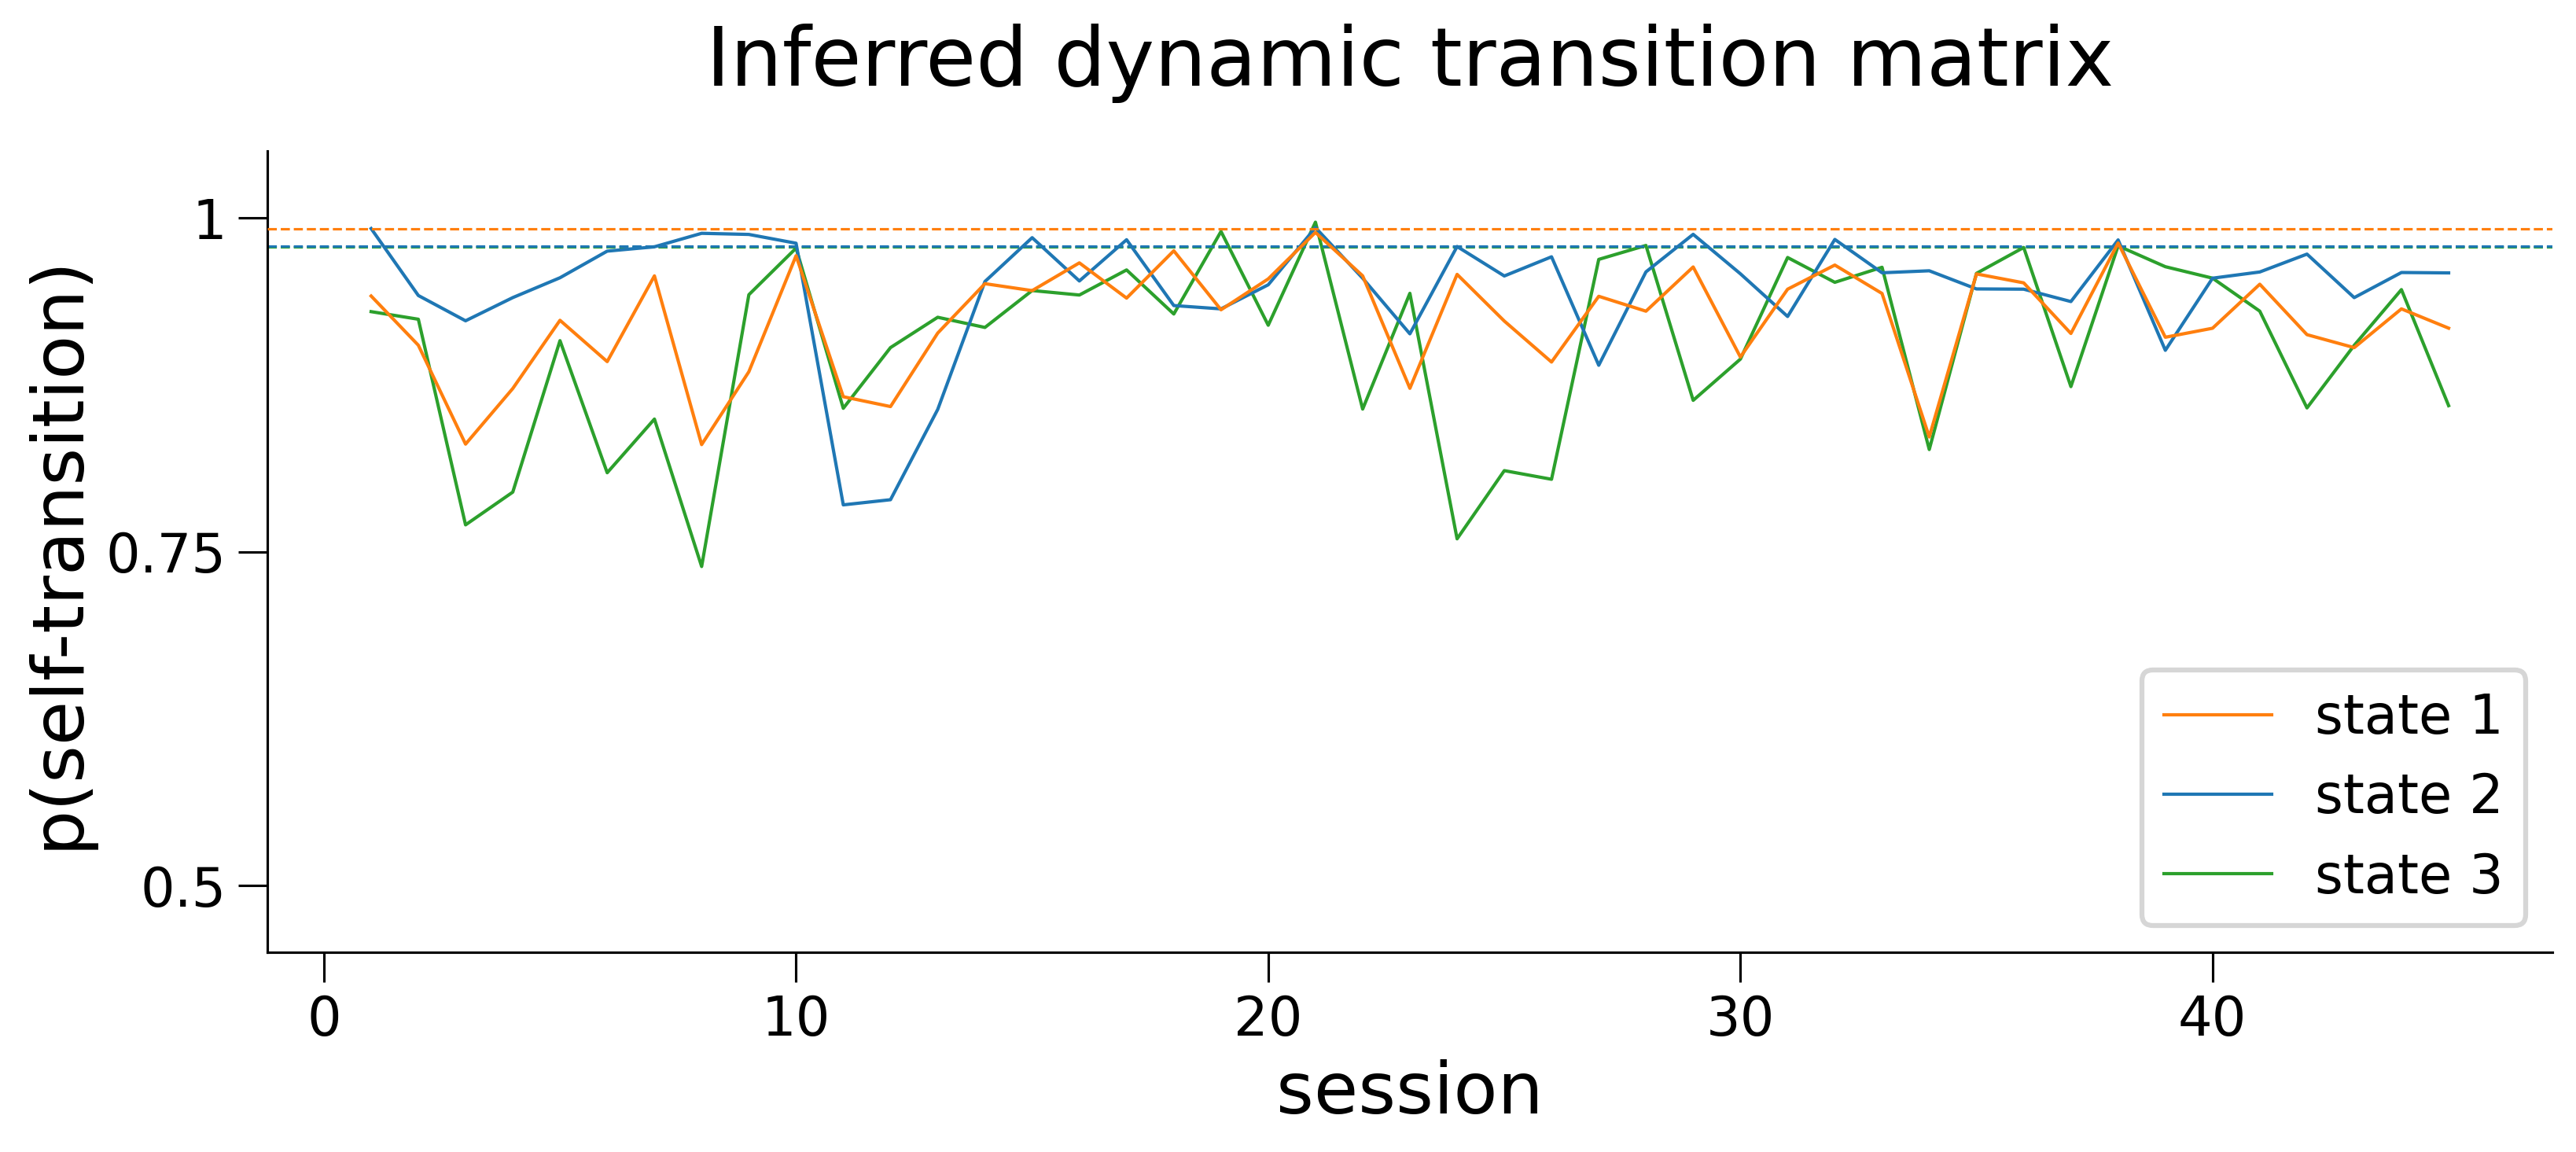

In [10]:
# plotting inferred dynamic self-transition probabilities
fig, axes = plt.subplots(1, figsize = (12.5,4.5), dpi=300) 
sess = len(sessInd)-1
for i in range(0,reshaped_best_P_dynamic.shape[1]):
    axes.axhline(reshaped_best_P_static[0,i,i], linestyle='--', linewidth=0.75, color=colorsStates[i], zorder=reshaped_best_P_dynamic.shape[1]-i, markersize=8)
    axes.plot(range(1,plotSess+1),reshaped_best_P_dynamic[sessInd[:plotSess],i,i],'-', linewidth=1, color=colorsStates[i], label=f'state {i+1}', zorder=reshaped_best_P_dynamic.shape[1]-i, markersize=8)
axes.set_ylabel("p(self-transition)", size=22)
axes.set_xlabel('session', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.set_title('Inferred dynamic transition matrix', size=25, pad=20)
axes.set_ylim(0.45,1.05)
axes.set_yticks([0.5,0.75,1],[0.5,0.75,1])
axes.set_xticks(range(0,50,10), range(0,50,10))
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.legend(loc='lower right')
plt.savefig(f'../figures/Self-transition_probabilties-alpha={bestAlpha}_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)
        

# Figure 2C

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


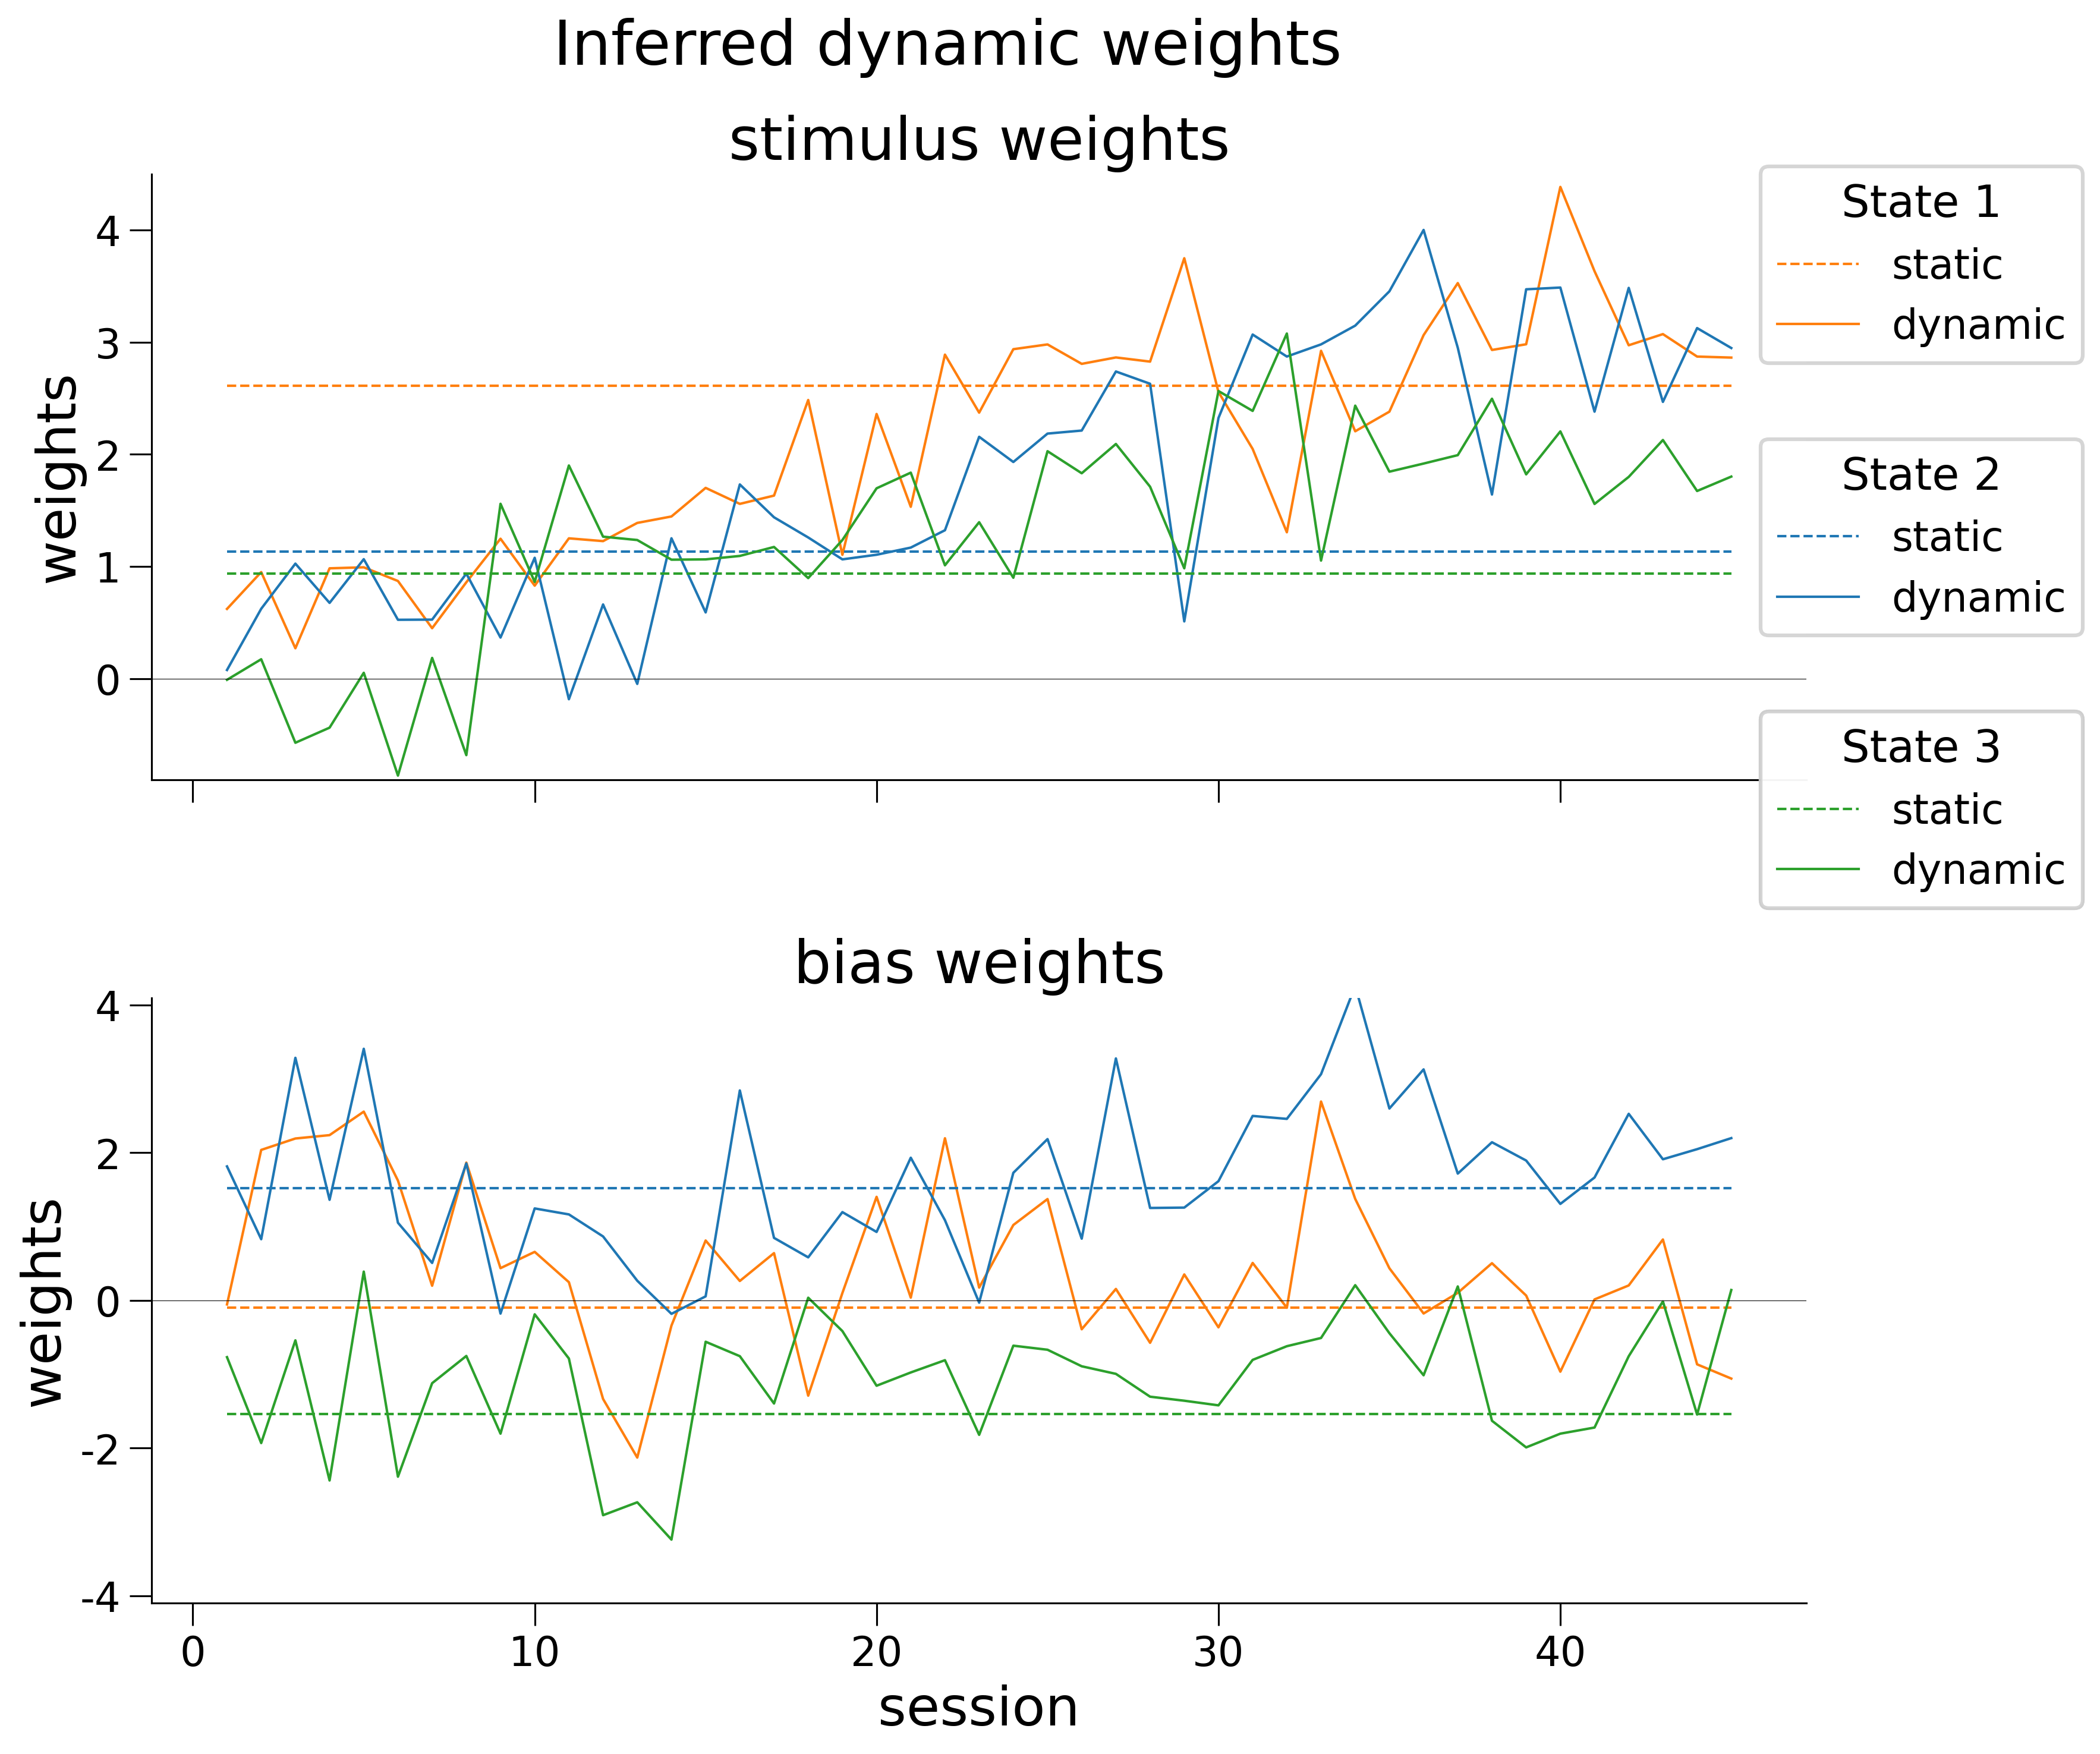

In [11]:
# plotting inferred dynamic weights
fig, axes = plt.subplots(2, 1,figsize=(12,10.5), sharex=True, dpi=300)
fig.tight_layout(pad=4)
yLim=[[-4.1,4.1],[-0.9,4.5]]
for d in range(0, 2):
    axes[d].axhline(0, color='black',linestyle='-', linewidth=0.25)
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),reshaped_best_W_static[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=1, alpha=1, linestyle='--', label='static', zorder=1)
        axes[d].plot(range(1,plotSess+1),reshaped_best_W_dynamic[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=1, alpha=1, linestyle='-', label='dynamic', zorder=1)
    axes[d].set_ylim(yLim[1-d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights', size=22)
    axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=24)
    axes[d].spines[['right', 'top']].set_visible(False)
    axes[d].spines[['left', 'bottom']].set_linewidth(0.75)
    axes[d].xaxis.set_tick_params(width=0.75)
    axes[d].yaxis.set_tick_params(width=0.75)
axes[1].set_yticks([-4,-2,0,2,4],[-4,-2,0,2,4])
lines = axes[0].get_lines()
include = [1,2]
legend1 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, 0.85), title = "State 1")
include = [3,4]
legend2 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, 0.4), title = "State 2")
include = [5,6]
legend3 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, -0.05), title = "State 3")
axes[0].add_artist(legend1)
axes[0].add_artist(legend2)
axes[0].add_artist(legend3)
axes[-1].set_xlabel('session', size=22)
fig.suptitle('Inferred dynamic weights', size=25)
plt.savefig(f'../figures/weights_sigma=1_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 2F

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


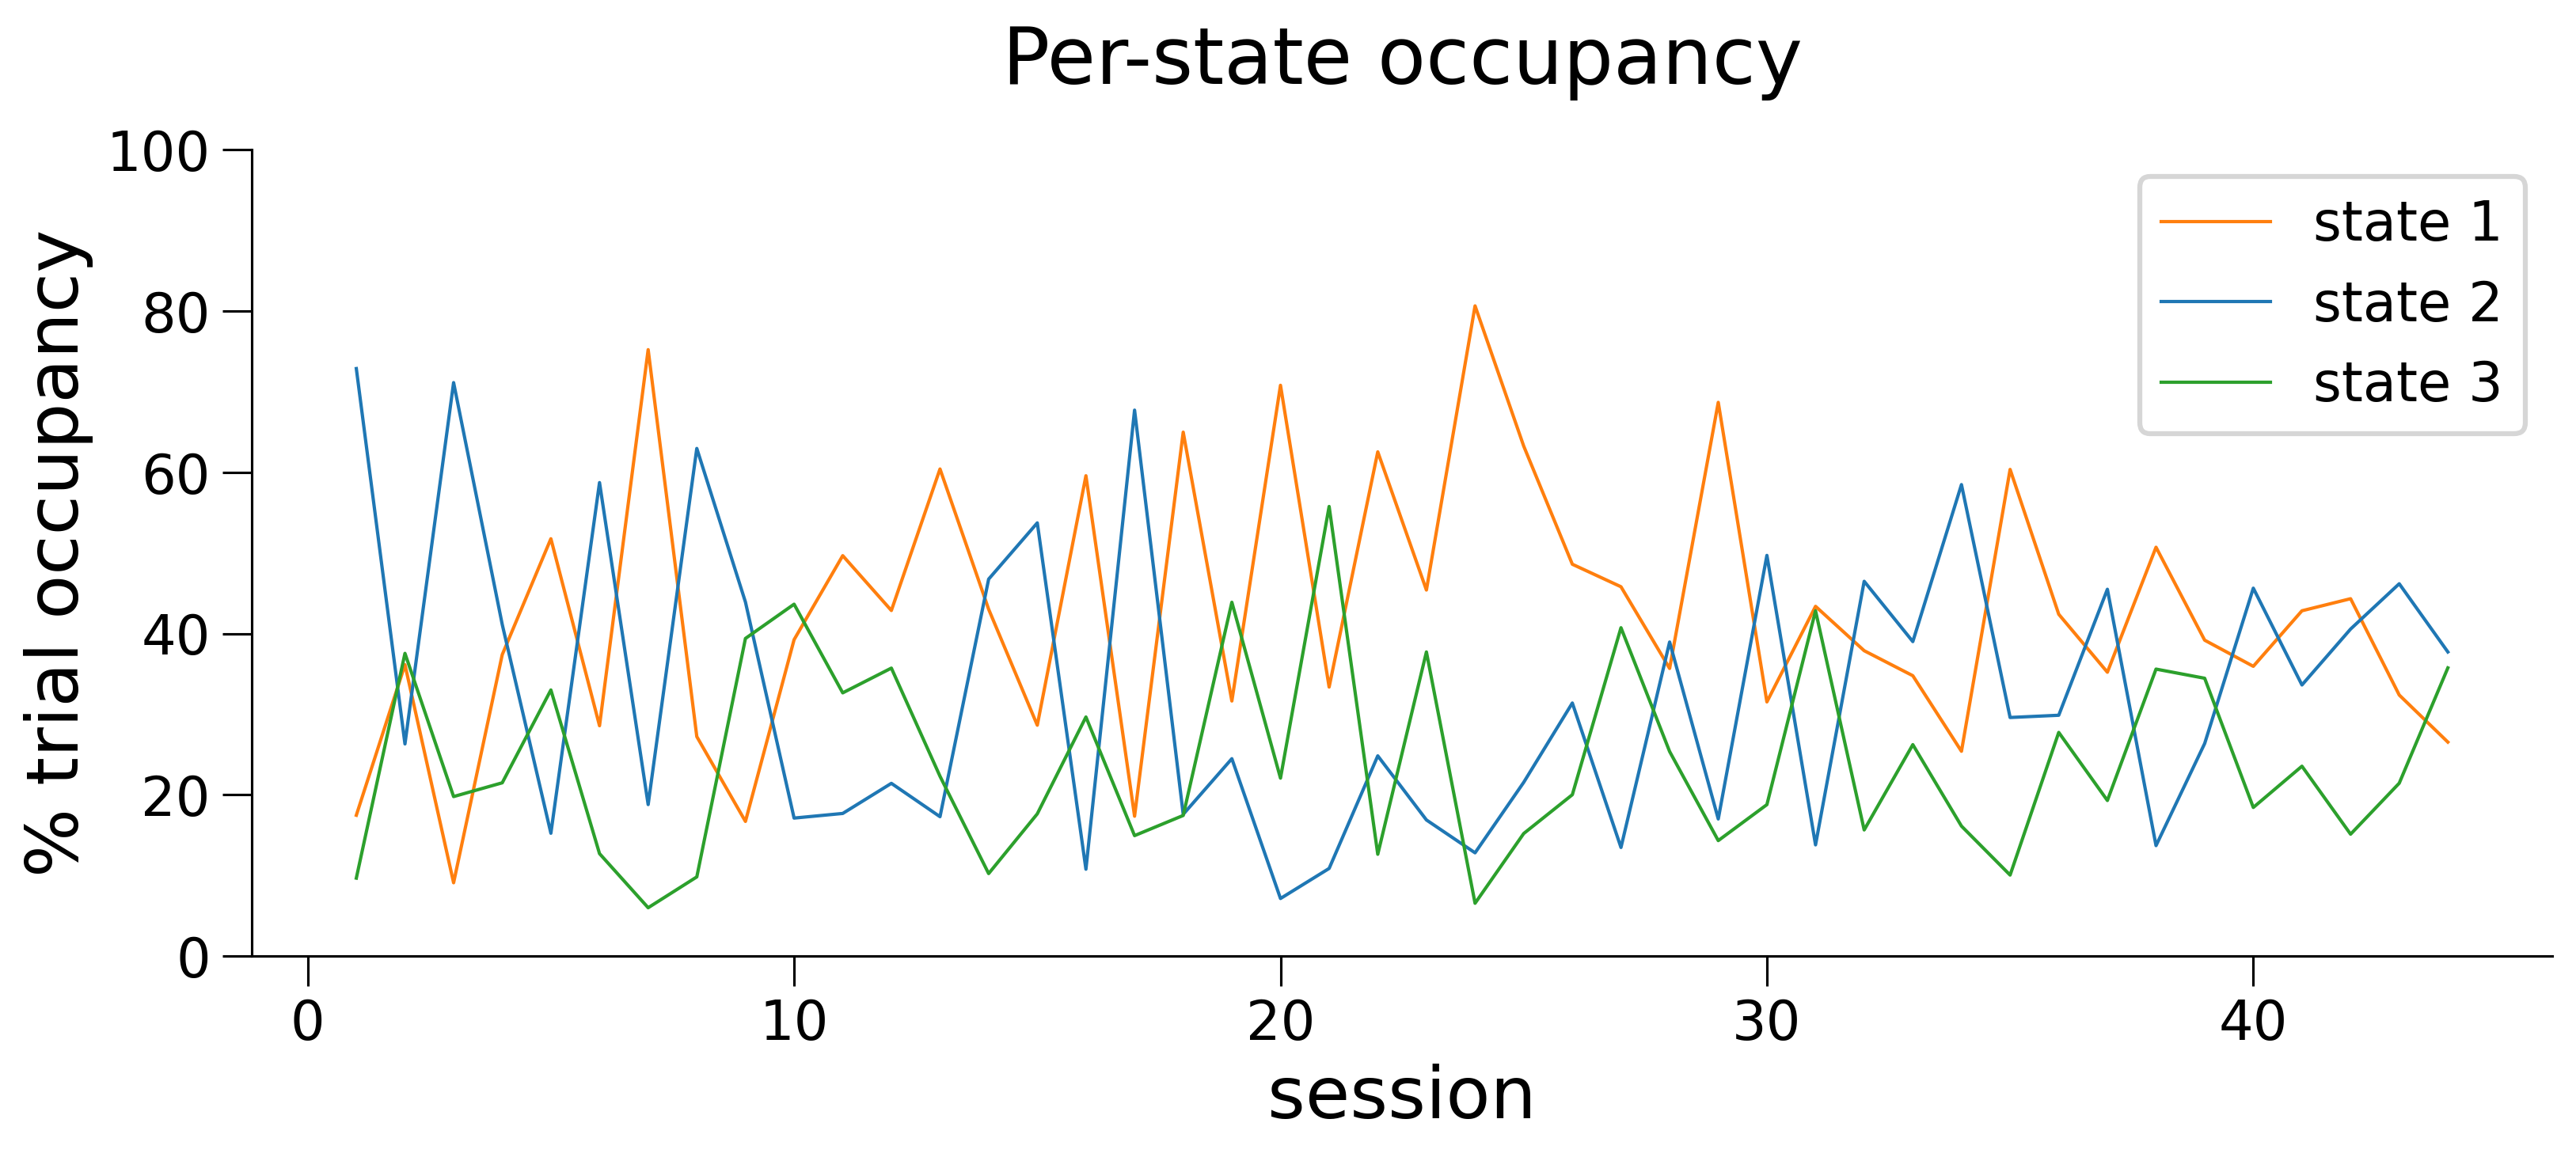

In [12]:
# Plotting task occupancy of each state across sessions
fig, axes = plt.subplots(1, figsize = (12.5,4.5), dpi=300) 
_ = plot_state_occupancy_sessions(gamma[:sessInd[plotSess]], sessInd[:plotSess], axes, colors=colorsStates, linewidth=1, size=24)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.set_title('Per-state occupancy', size=24, pad=20)
axes.legend()
axes.set_xlabel('session', size=22)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
plt.savefig(f'../figures/Occupancy_states_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)

# other way of computing occupancies (soft)
# p_occ_states_sessions = soft_occupancy_states_sessions(gamma, sessInd)
# for k in range(0,K):
#     axes[0].plot(range(1,len(sessInd)), p_occ_states_sessions[:,k], color=colorsStates[k], linewidth=3, label=f'state {k+1}')


# Figure 2D

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


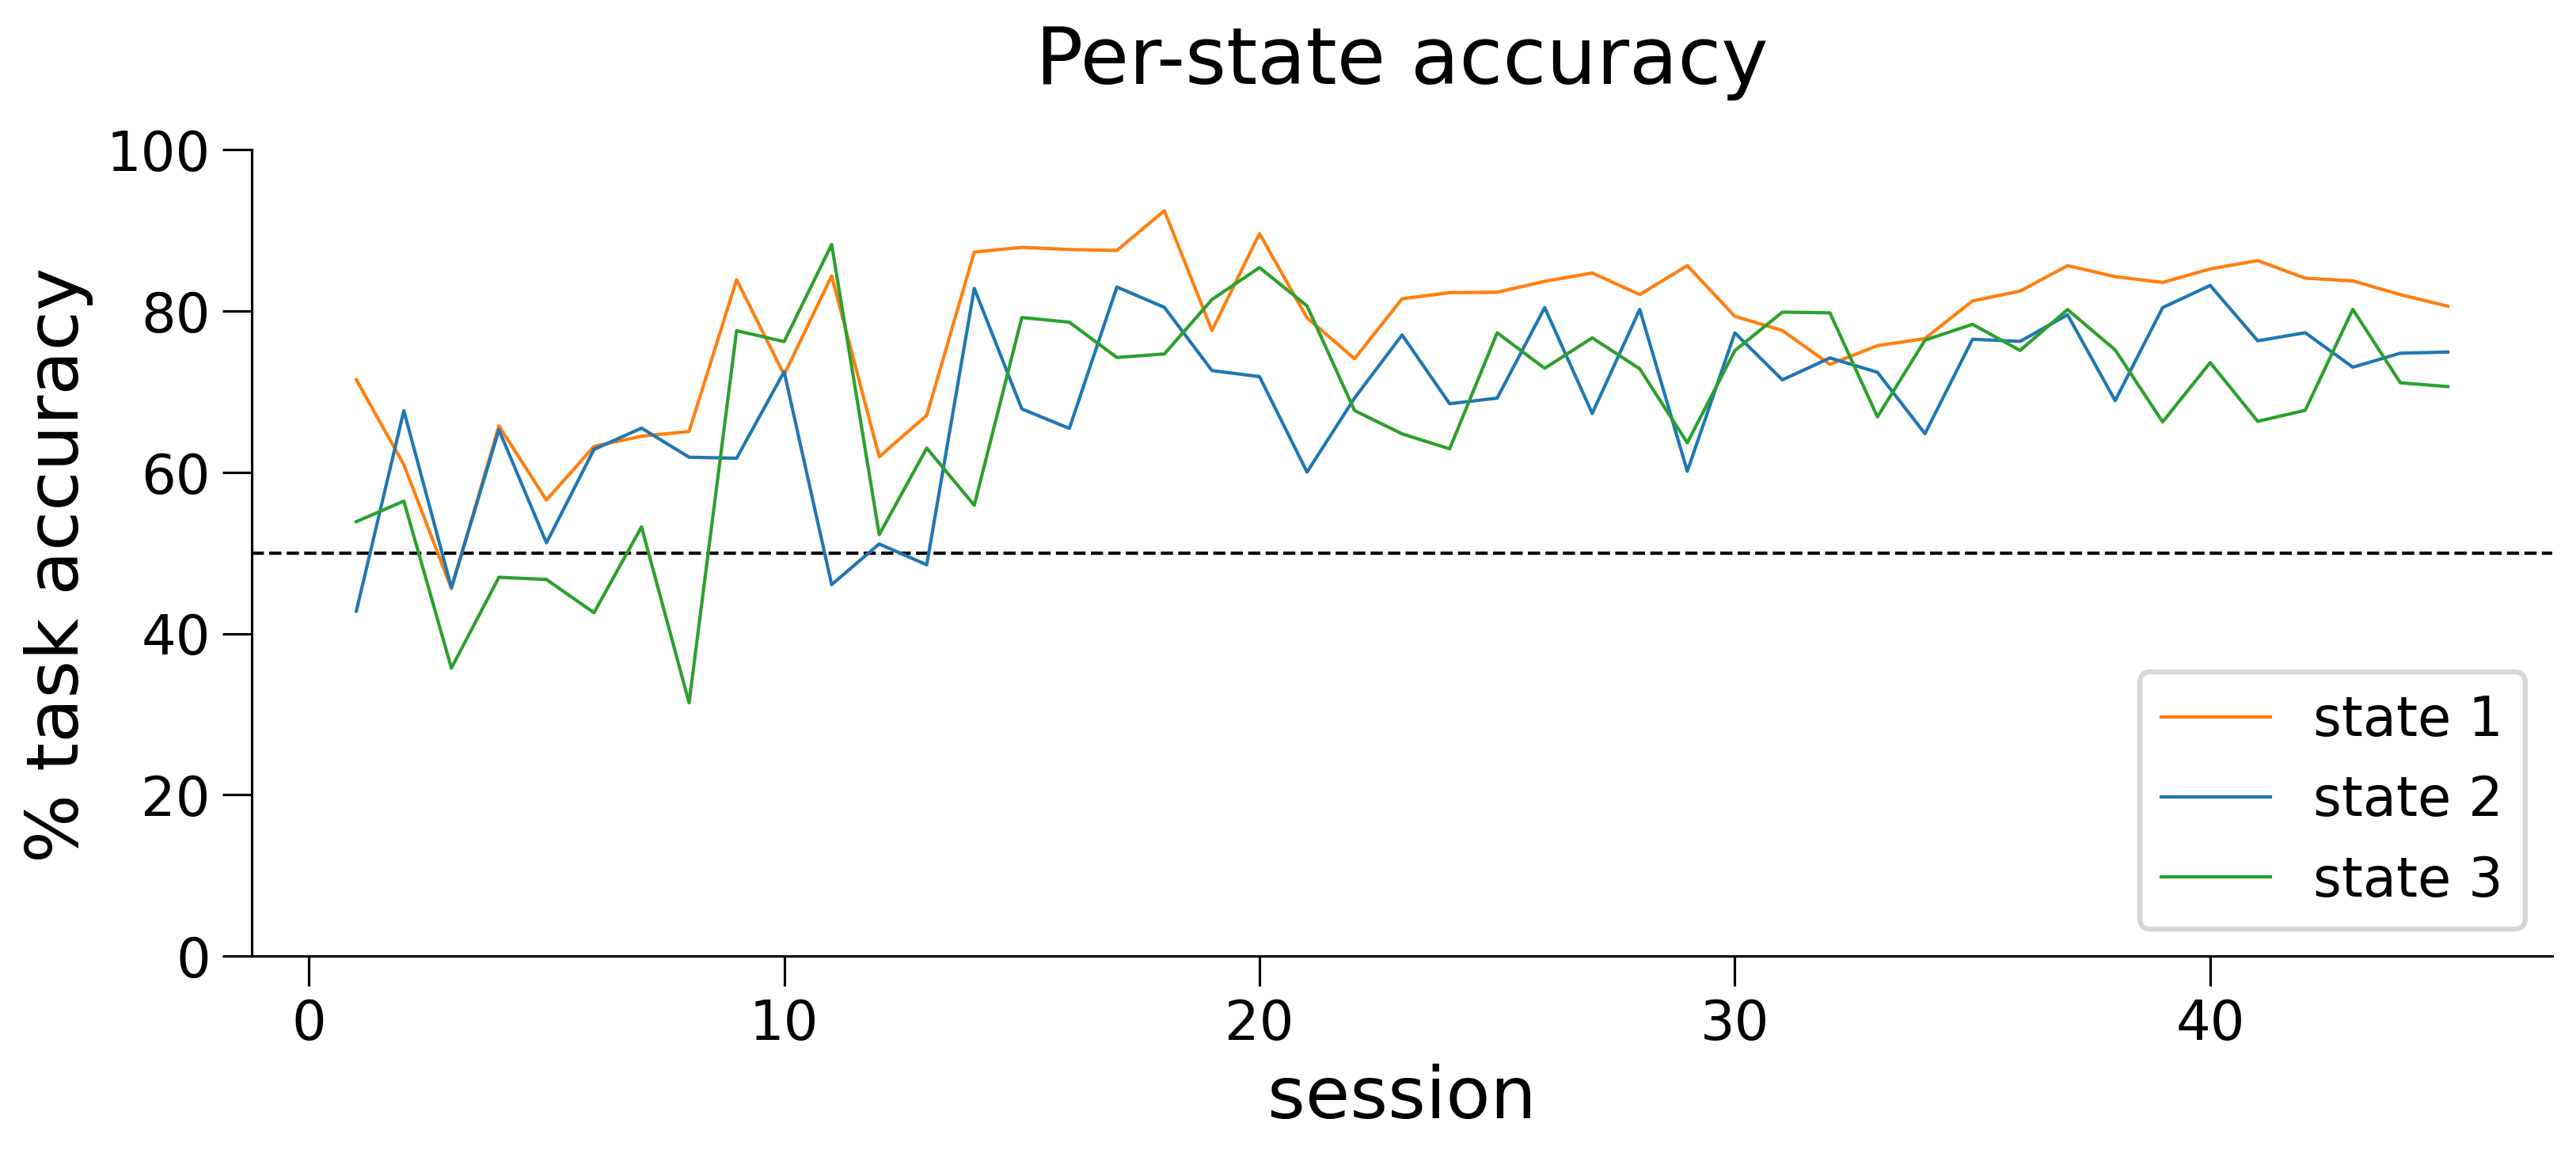

In [13]:
# copmuting task accuracy in each state across sessions
p_correct, p_correct_states, p_correct_sessions, p_correct_states_sessions = accuracy_states_sessions(gamma, phi, y, correctSide, sessInd)

# computing empirical accuracy
empiricalAccuracy = np.zeros((len(sessInd)-1))
correct = correctSide == y
for s in range(0,len(sessInd)-1):
    empiricalAccuracy[s] = np.mean(correct[sessInd[s]:sessInd[s+1]]) * 100

# plotting per-state task accuracy
fig, axes = plt.subplots(1, figsize = (12.5,4.5), sharex=True, dpi=300) 
axes.axhline(50, color='black', linestyle='dashed', linewidth=1)
for k in range(0,K):
    axes.plot(range(1,plotSess+1), p_correct_states_sessions[:plotSess,k], color=colorsStates[k], linewidth=1, label=f'state {k+1}')
axes.set_ylim(0,100)
axes.set_ylabel('% task accuracy ', size=22)
axes.set_xlabel('session', size=22)
axes.legend(loc='lower right')
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.set_title('Per-state accuracy', size=24, pad=20)
plt.savefig(f'../figures/Accuracy_states_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 2G

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


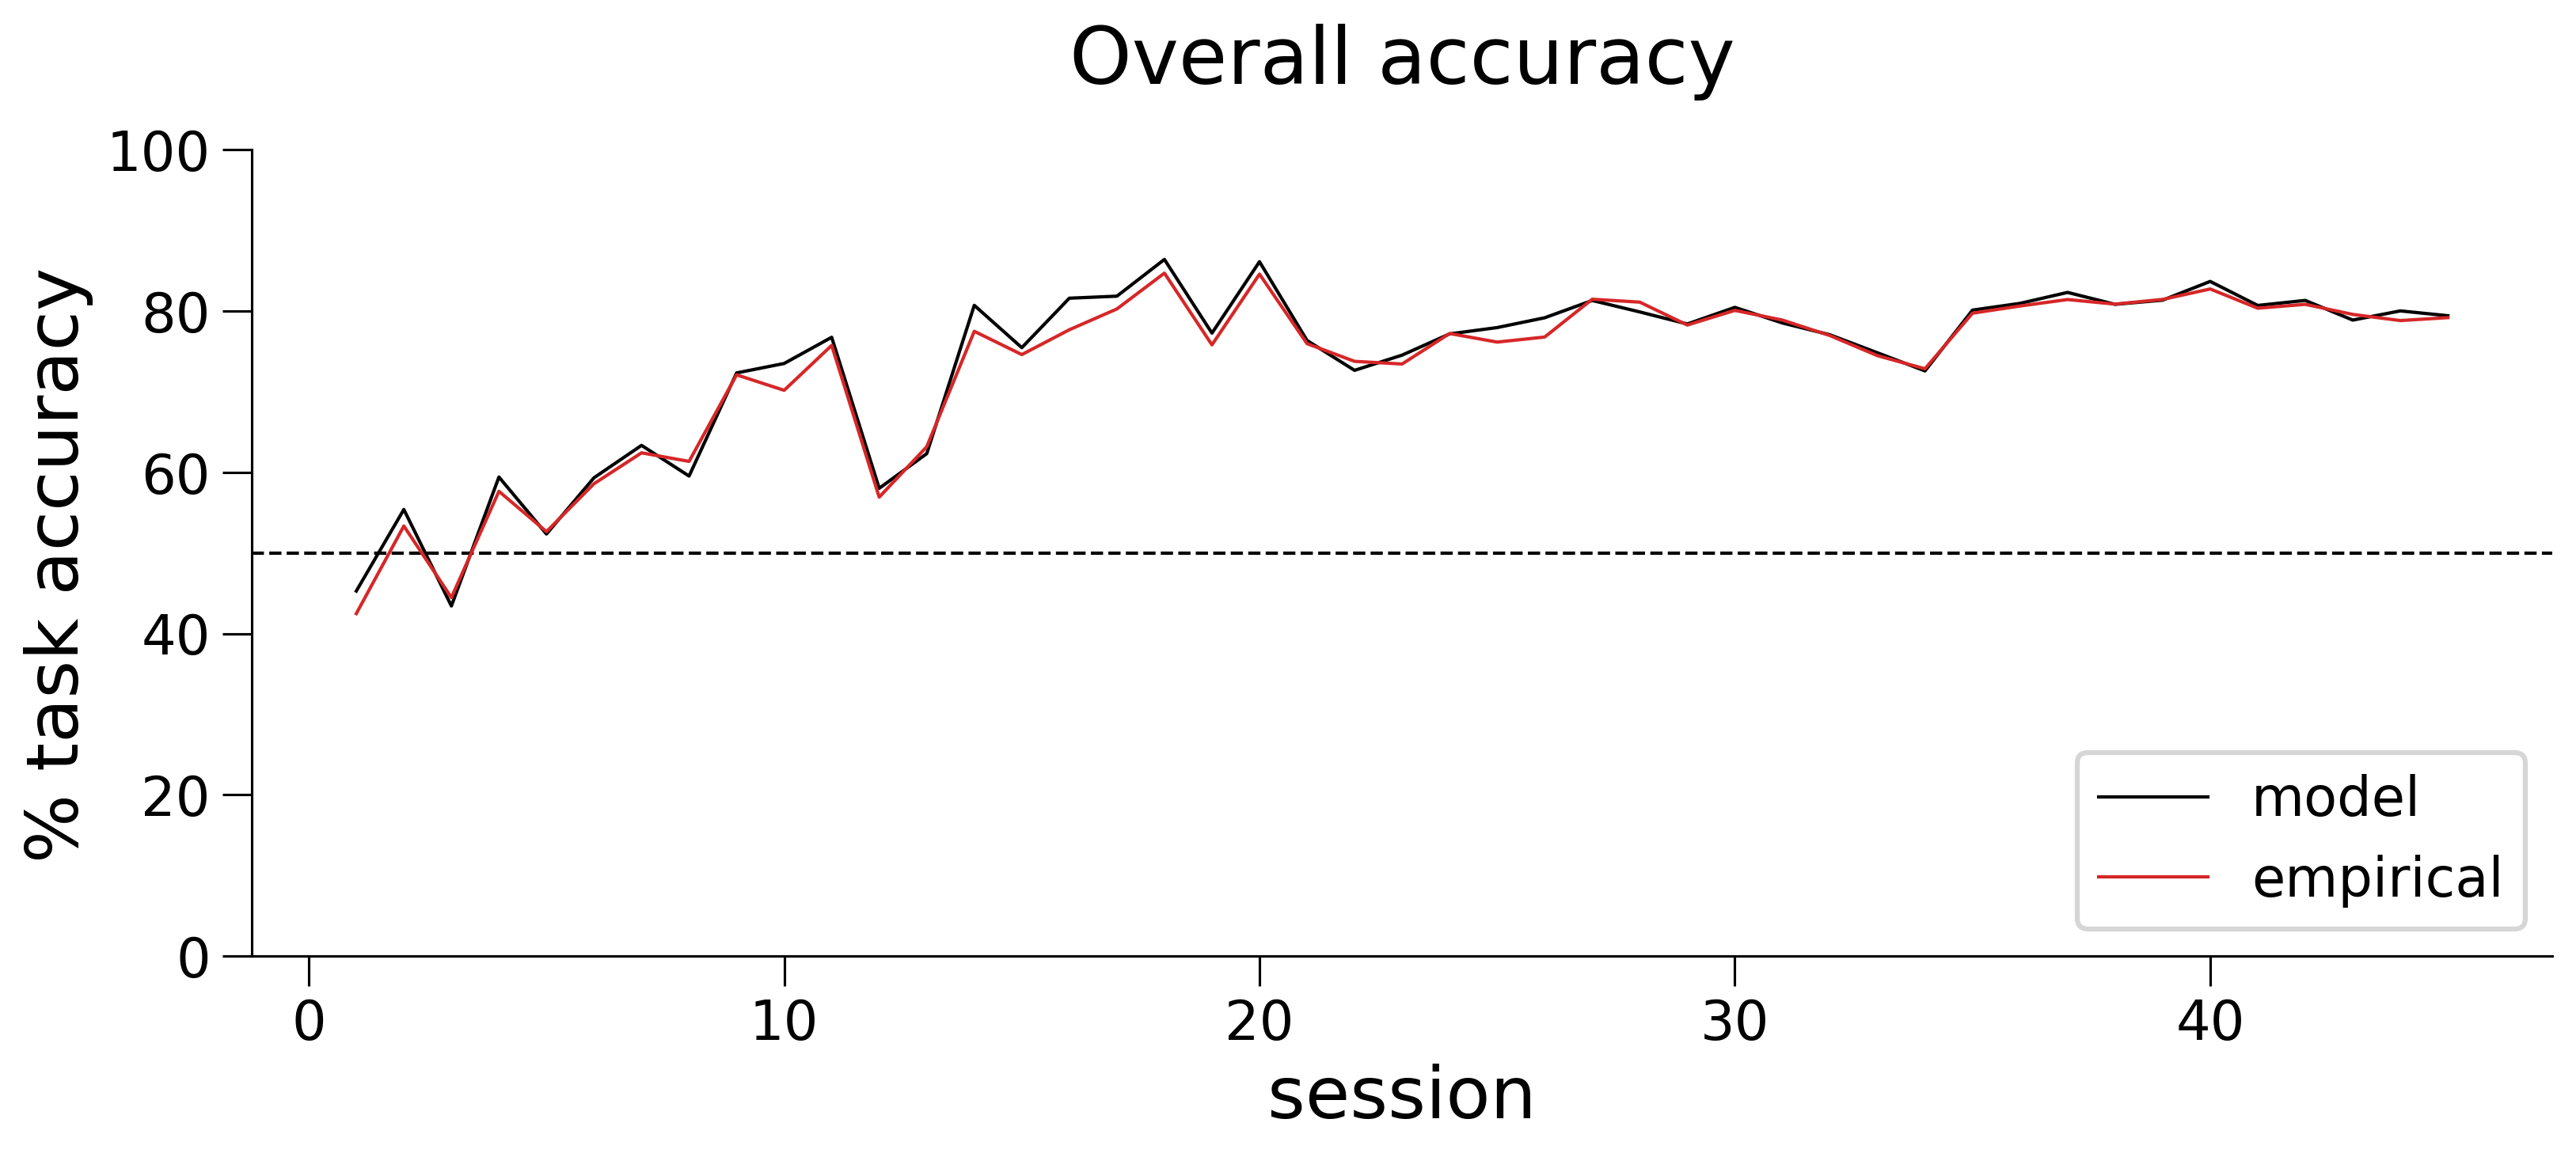

In [14]:
# plotting task accuracy (empirical vs model predicted based on 3 states together)
fig, axes = plt.subplots(1, figsize = (12.5,4.5), sharex=True, dpi=300) 
axes.plot(range(1,plotSess+1), p_correct_sessions[:plotSess], color='black', linewidth=1, label='model')
axes.plot(range(1,plotSess+1), empiricalAccuracy[:plotSess], color='tab:red', linewidth=1, label='empirical')
axes.set_ylim(0,100)
axes.set_ylabel('% task accuracy ', size=22)
axes.set_xlabel('session', size=22)
axes.axhline(50,color='black',linestyle='dashed', zorder=0, linewidth=1)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_title('Overall accuracy', size=24, pad=20)
axes.legend(loc='lower right')
plt.savefig(f'../figures/Overall_accuracy_states_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 3A

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


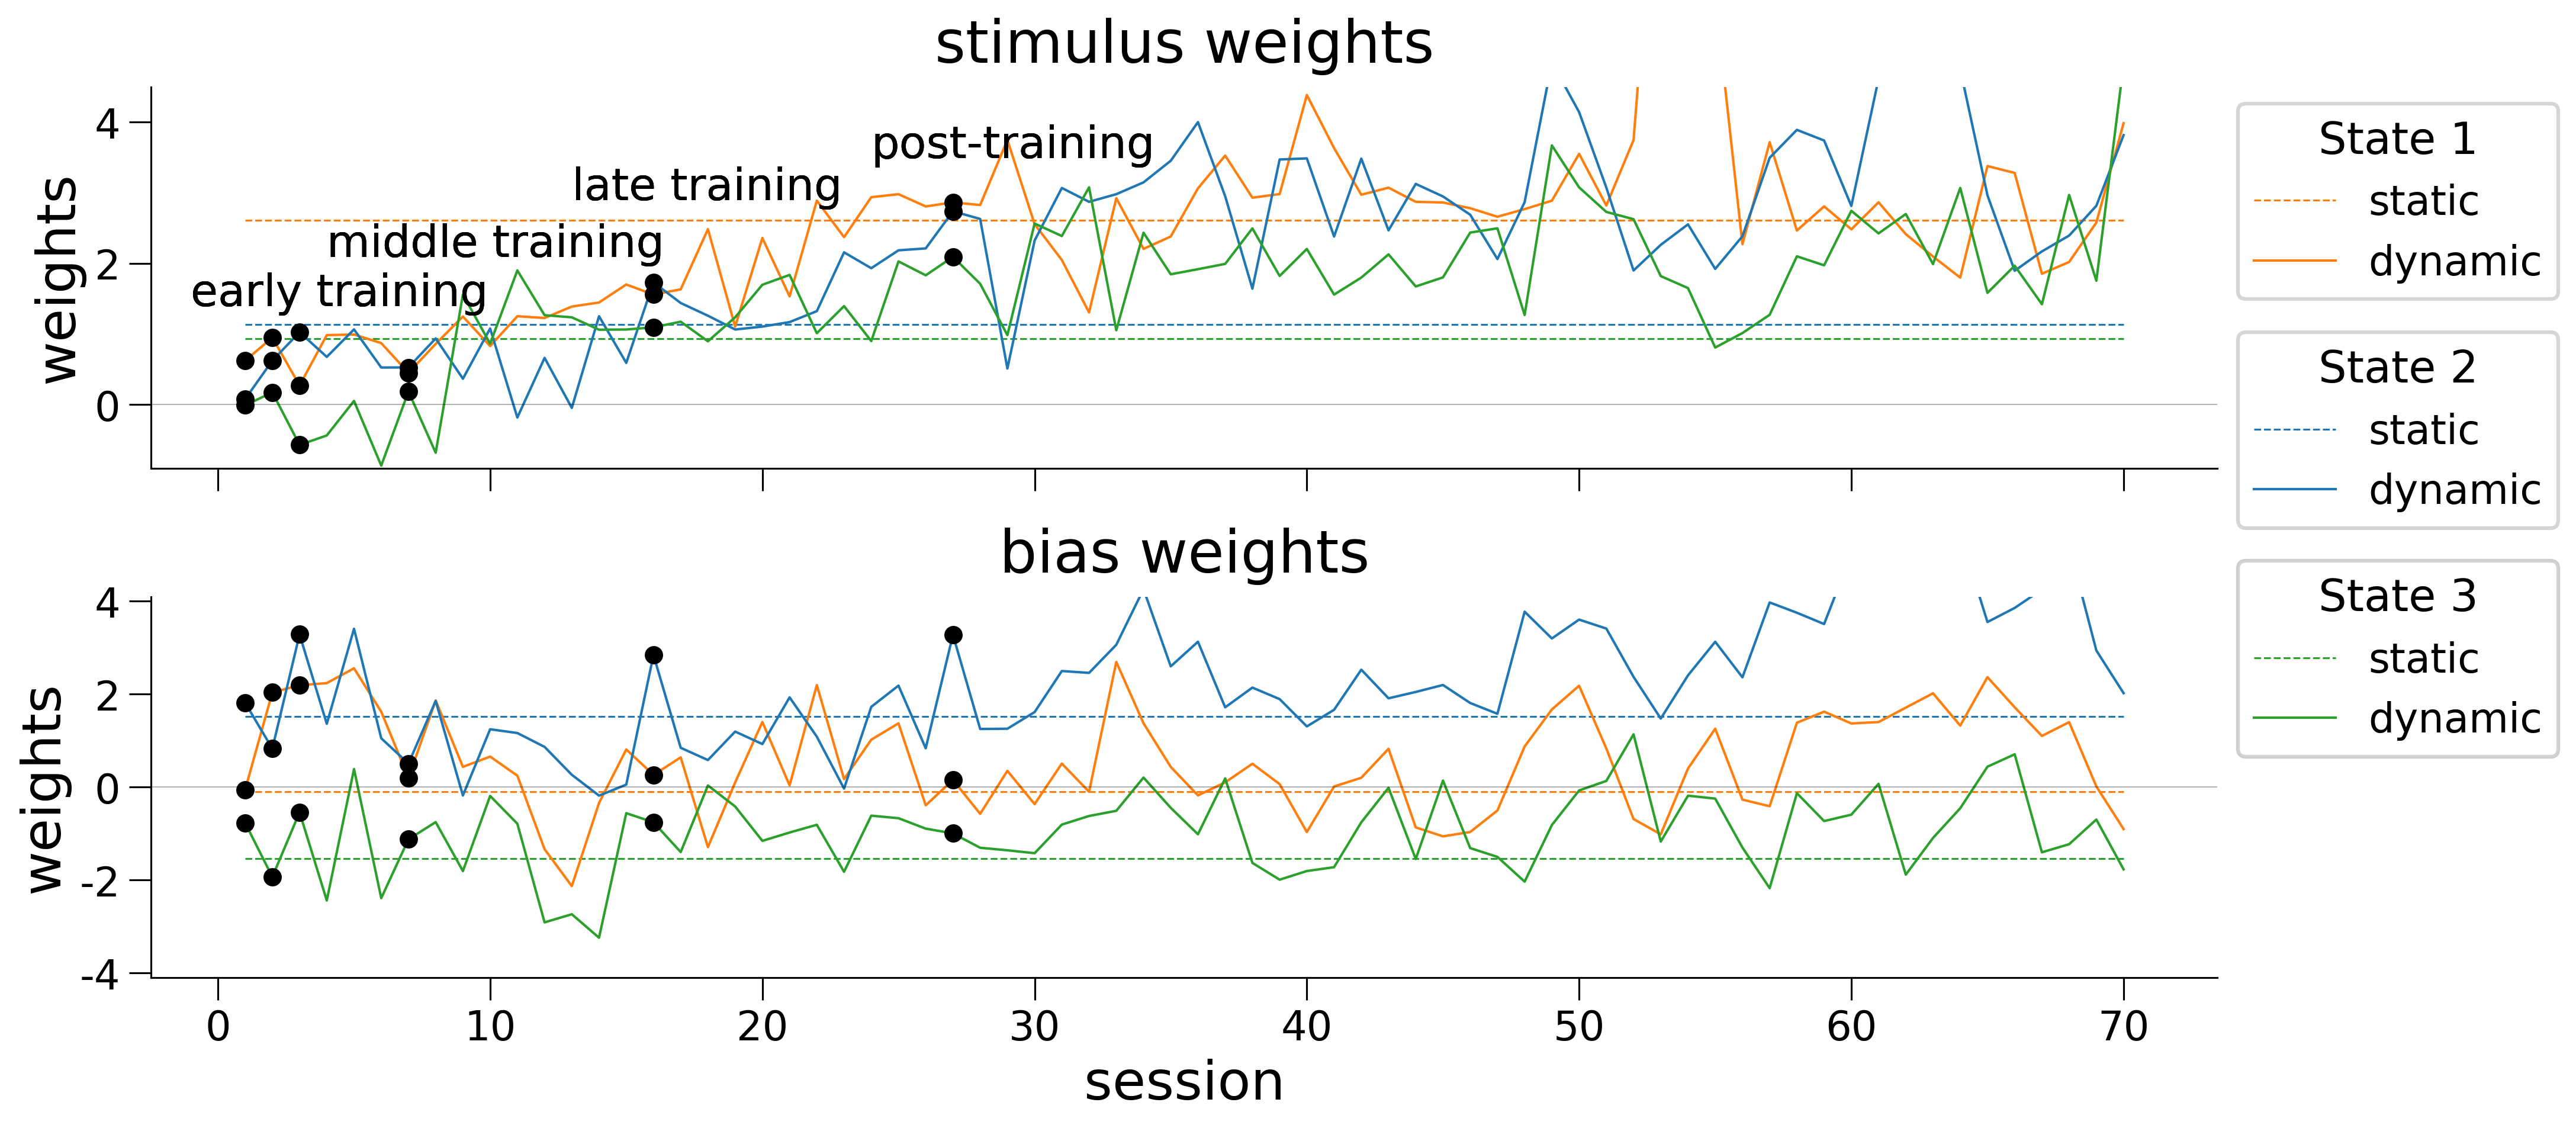

In [23]:
# example sessions for further investigation
sessionsInterest = [0,1,2,6,15,26]
sessionTitle = ['early training','early training','early training','middle training','late training','post-training'] 

# plotting inferred dynamic weights again with marks on example sessions
fig, axes = plt.subplots(2, 1,figsize=(13.5,6.5), sharex=True, dpi=300)
fig.tight_layout(pad=2)
yLim=[[-4.1,4.1],[-0.9,4.5],[-4.1,4.1],[-4.1,4.1]]
yText = [[1.4,1.4,1.4,2.1,2.9,3.5]]
for d in range(0, 2):
    axes[d].axhline(0, alpha=0.3, color='black',linestyle='-',linewidth=0.5)
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),reshaped_best_W_static[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=0.75, alpha=1, linestyle='--', label='static', zorder=0)
        axes[d].plot(range(1,plotSess+1),reshaped_best_W_dynamic[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=1, alpha=1, label=f'dynamic', linestyle='-', zorder=1)
        for s in range(0,len(sessionsInterest)):
            axes[d].scatter(sessionsInterest[s]+1, reshaped_best_W_dynamic[sessInd[sessionsInterest[s]],k,1-d,1], color='black', zorder=2, s=35)
            if (d==0 and s not in [0,2]):
                axes[d].text(sessionsInterest[s]-2, yText[d][s], sessionTitle[s])
    axes[d].set_ylim(yLim[1-d])
    axes[d].set_ylabel(f'weights', size=22)
    axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=24, pad=10)
    axes[d].spines[['right', 'top']].set_visible(False)
    axes[d].spines[['left', 'bottom']].set_linewidth(0.75)
    axes[0].legend(loc=(1.02,0.2))
    axes[d].xaxis.set_tick_params(width=0.75)
    axes[d].yaxis.set_tick_params(width=0.75)
axes[1].set_yticks([-4,-2,0,2,4],[-4,-2,0,2,4])

lines = axes[0].get_lines()
include = [1,2]
legend1 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(1, 0.7), title = "State 1")
include = [3,4]
legend2 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(1, 0.1), title = "State 2")
include = [5,6]
legend3 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(1, -0.5), title = "State 3")
axes[0].add_artist(legend1)
axes[0].add_artist(legend2)
axes[0].add_artist(legend3)
axes[-1].set_xlabel('session', size=22)
plt.savefig(f'../figures/weights_fig4_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 3C

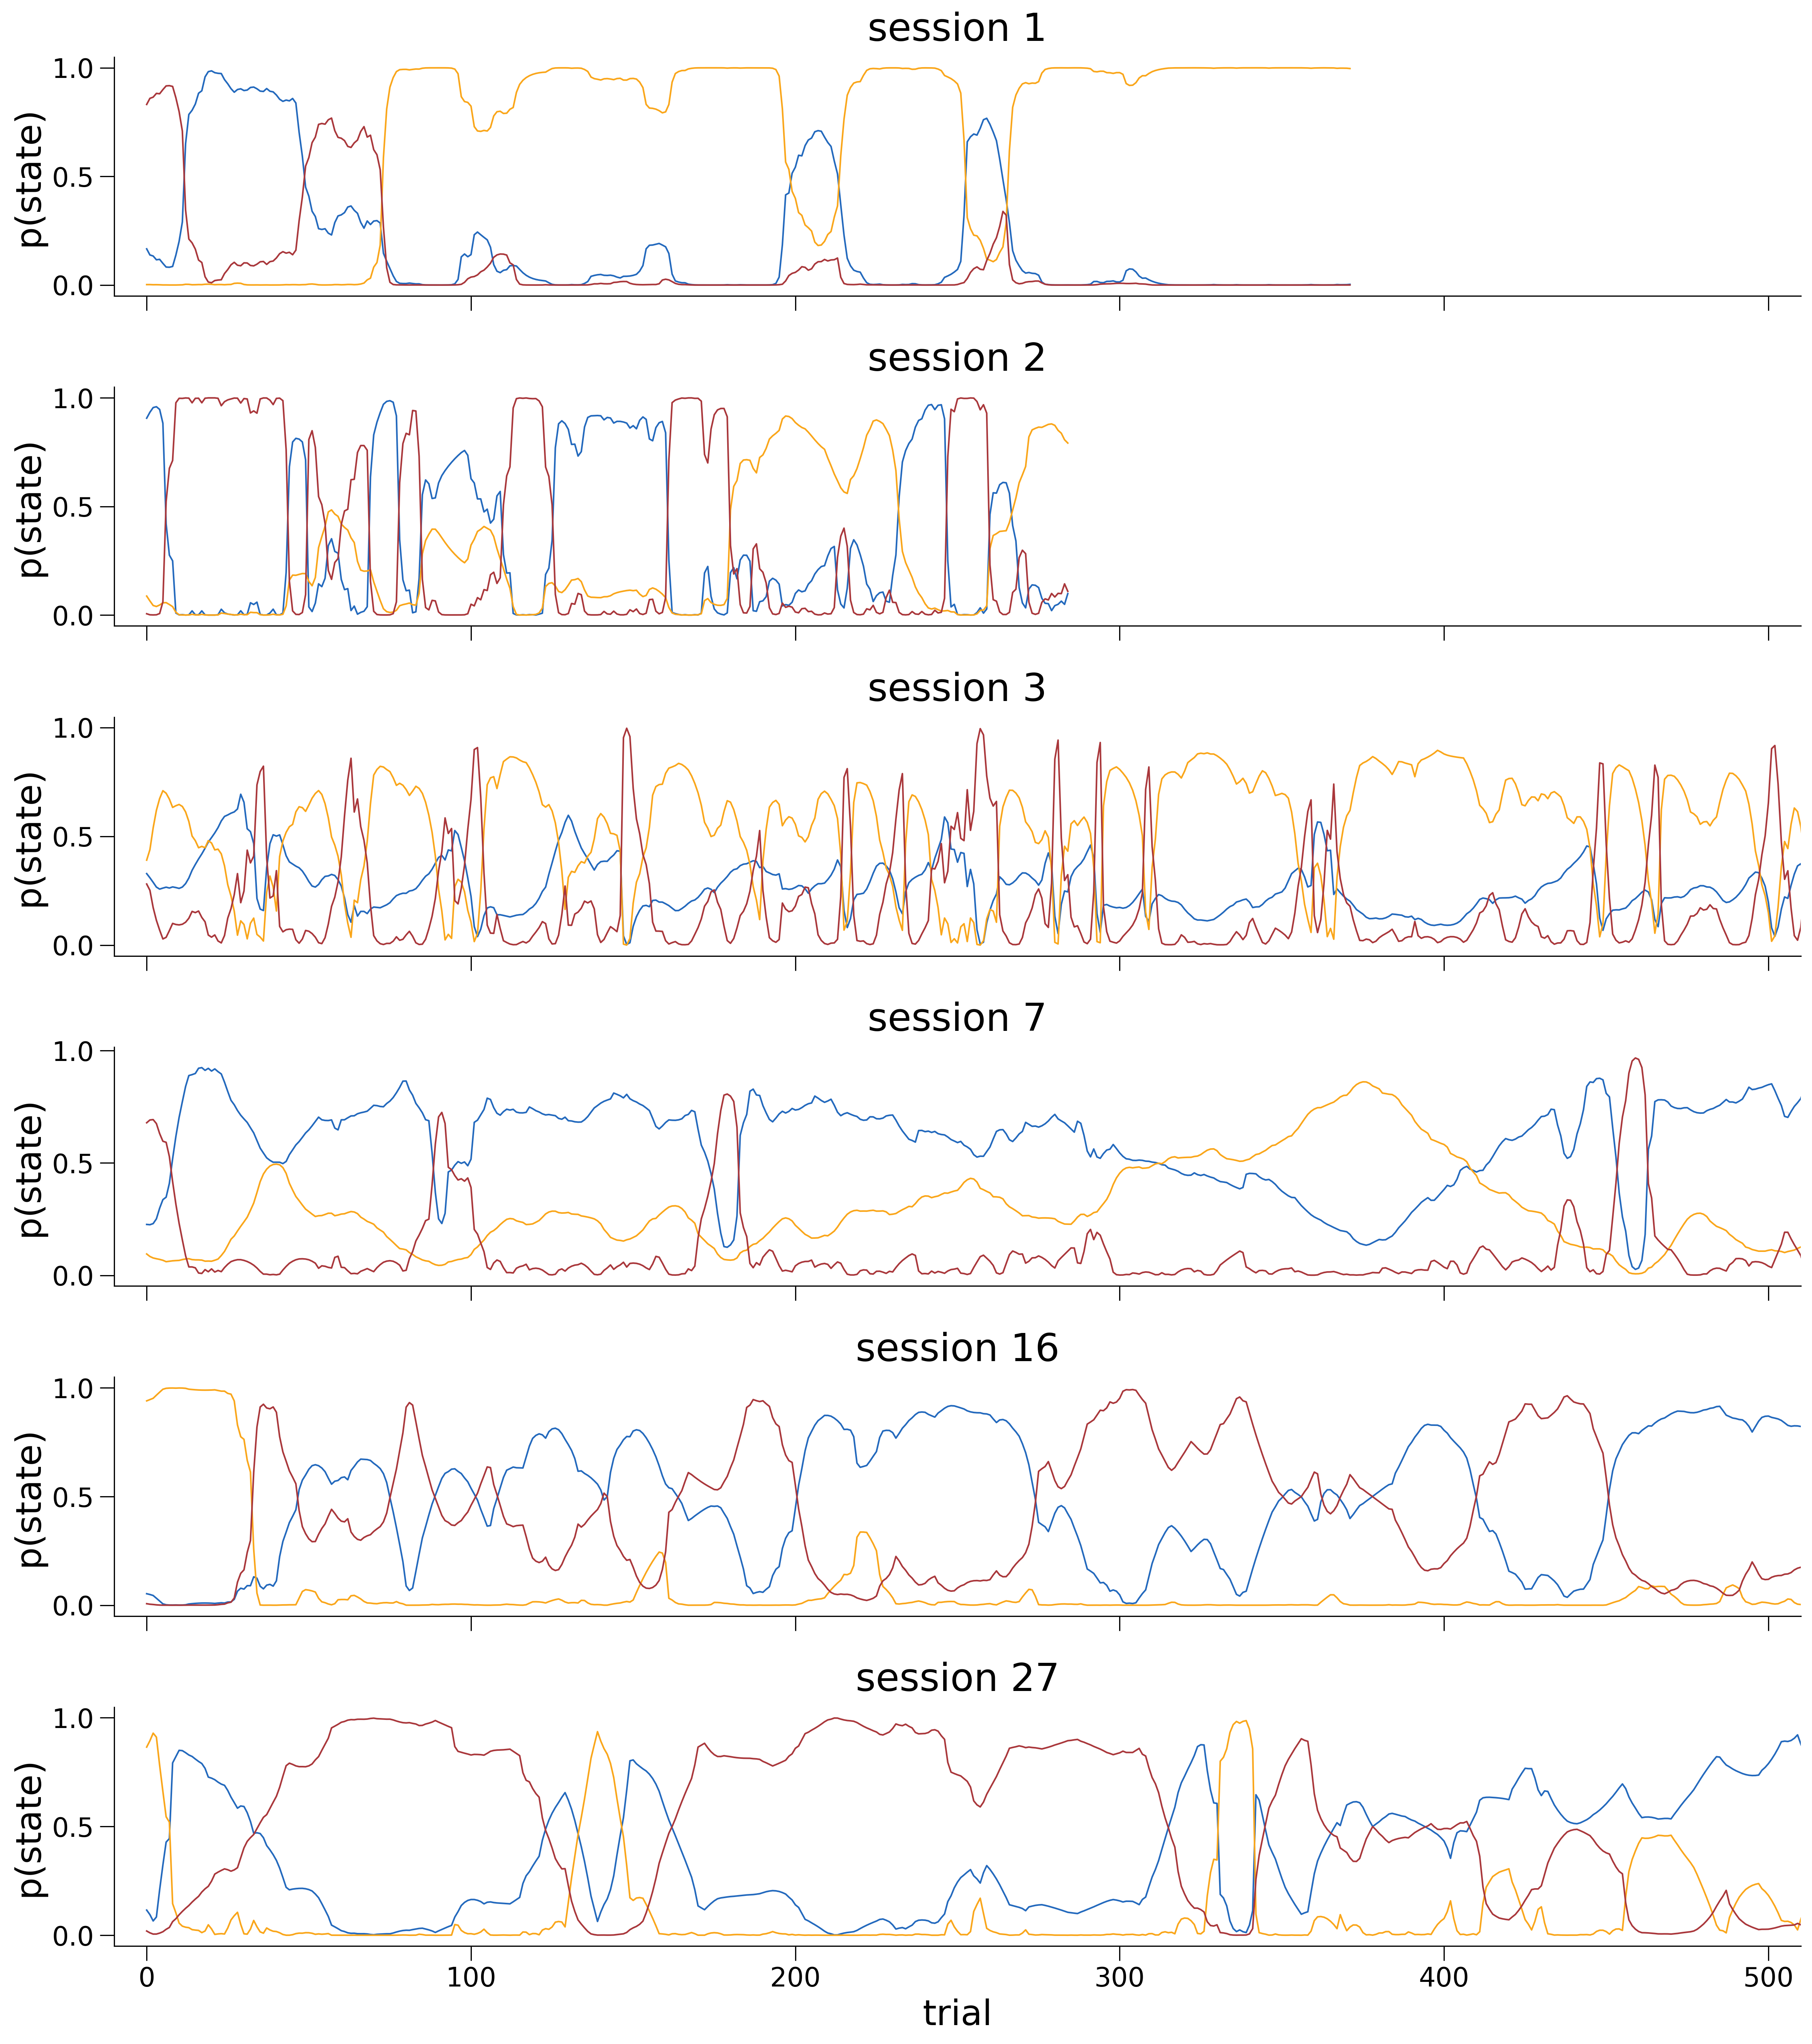

In [16]:
# plotting inferred likelihood of being in each state for example sessions
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(16,len(sessionsInterest)*3), dpi=300, sharex=True)
fig.tight_layout(pad=3.5)
plot_posteior_latent(gamma, sessInd, axes, sessions = sessionsInterest, linewidth=1)
for s in range(0,len(sessionsInterest)):
    sess = sessionsInterest[s]
    # for t in range(sessInd[sess],sessInd[sess+1]):
    #     if (biasedBlockTrials[t] == 1):
    #         axes[s].axvline(t-sessInd[sess], color='tab:blue', label='right block', zorder=0, alpha=0.3, linewidth=0.85)
    #     elif (biasedBlockTrials[t] == -1):
    #         axes[s].axvline(t-sessInd[sess], color='tab:green', label='left block', zorder=0, alpha=0.3, linewidth=0.85)
    axes[s].set_xlim(-10,510)
    axes[s].set_title(f'session {sessionsInterest[s]+1}', size=24, pad=10)
    axes[s].spines[['right', 'top']].set_visible(False)
    axes[s].spines[['left', 'bottom']].set_linewidth(0.75)
    axes[s].get_legend().remove()
    axes[s].set_ylabel('p(state)', size=22)
    axes[s].xaxis.set_tick_params(width=0.75)
    axes[s].yaxis.set_tick_params(width=0.75)
axes[-1].set_xlabel('trial', size=22)
fig.tight_layout()
plt.savefig(f'../figures/posterior_latent_example-sessions_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)


# Figure 3B

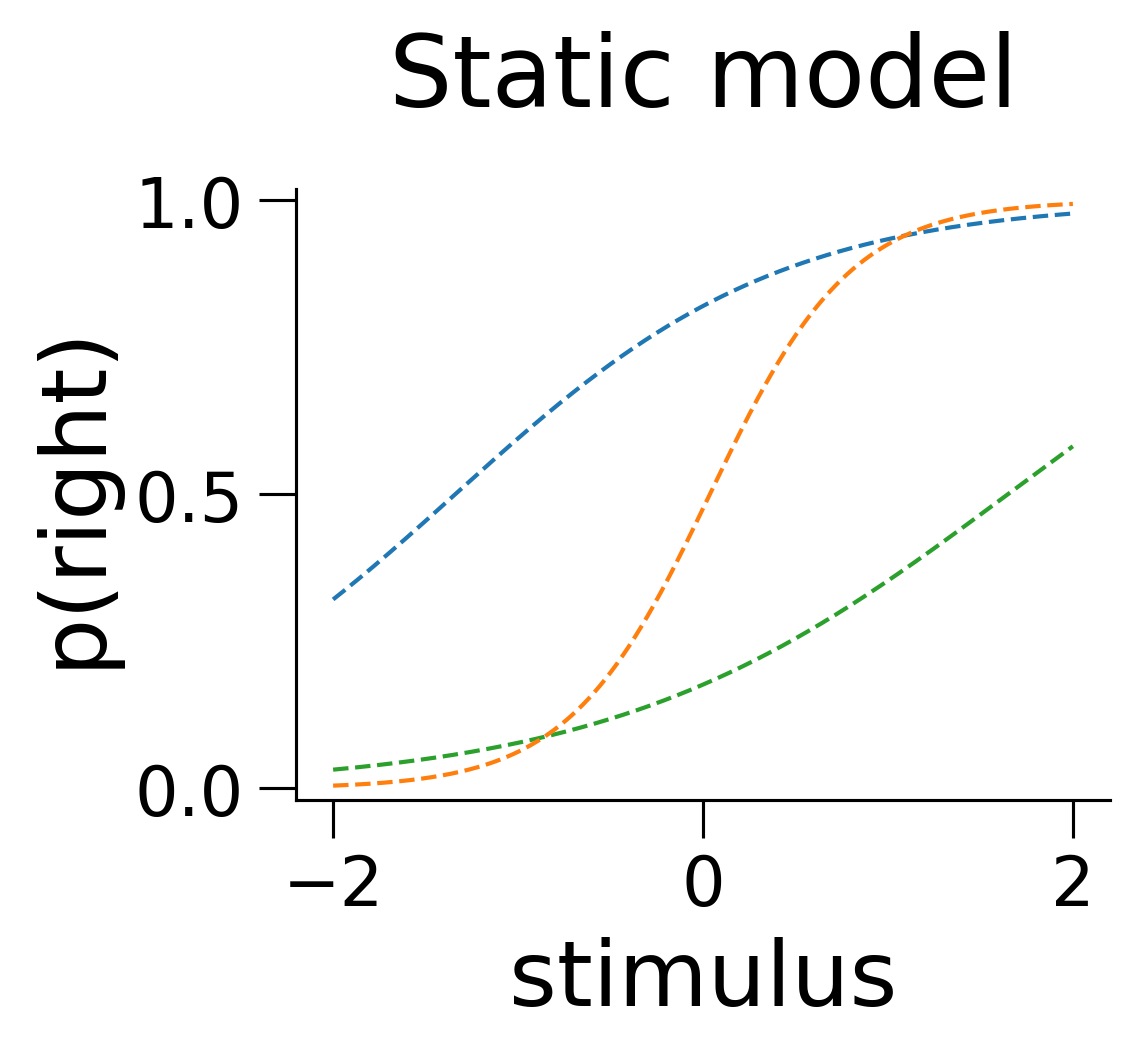

In [17]:
# plotting per-state psychometrics for static (standard) GLM-HMM
fig, axes = plt.subplots(figsize=(3.5,2.7), dpi=300)
plotting_psychometric(w=reshaped_best_W_static, sessInd=sessInd, session=sessionsInterest[s], axes=axes, colorsStates=colorsStates, linestyle='--', linewidth=1)
axes.set_title(f'Static model', size=24, pad=20)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.set_ylabel('p(right)', size=22)
axes.set_xlabel('stimulus', size=22)
axes.get_legend().remove()
axes.set_ylim(-0.02,1.02)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
plt.savefig(f'../figures/psychometric{s}_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 3D

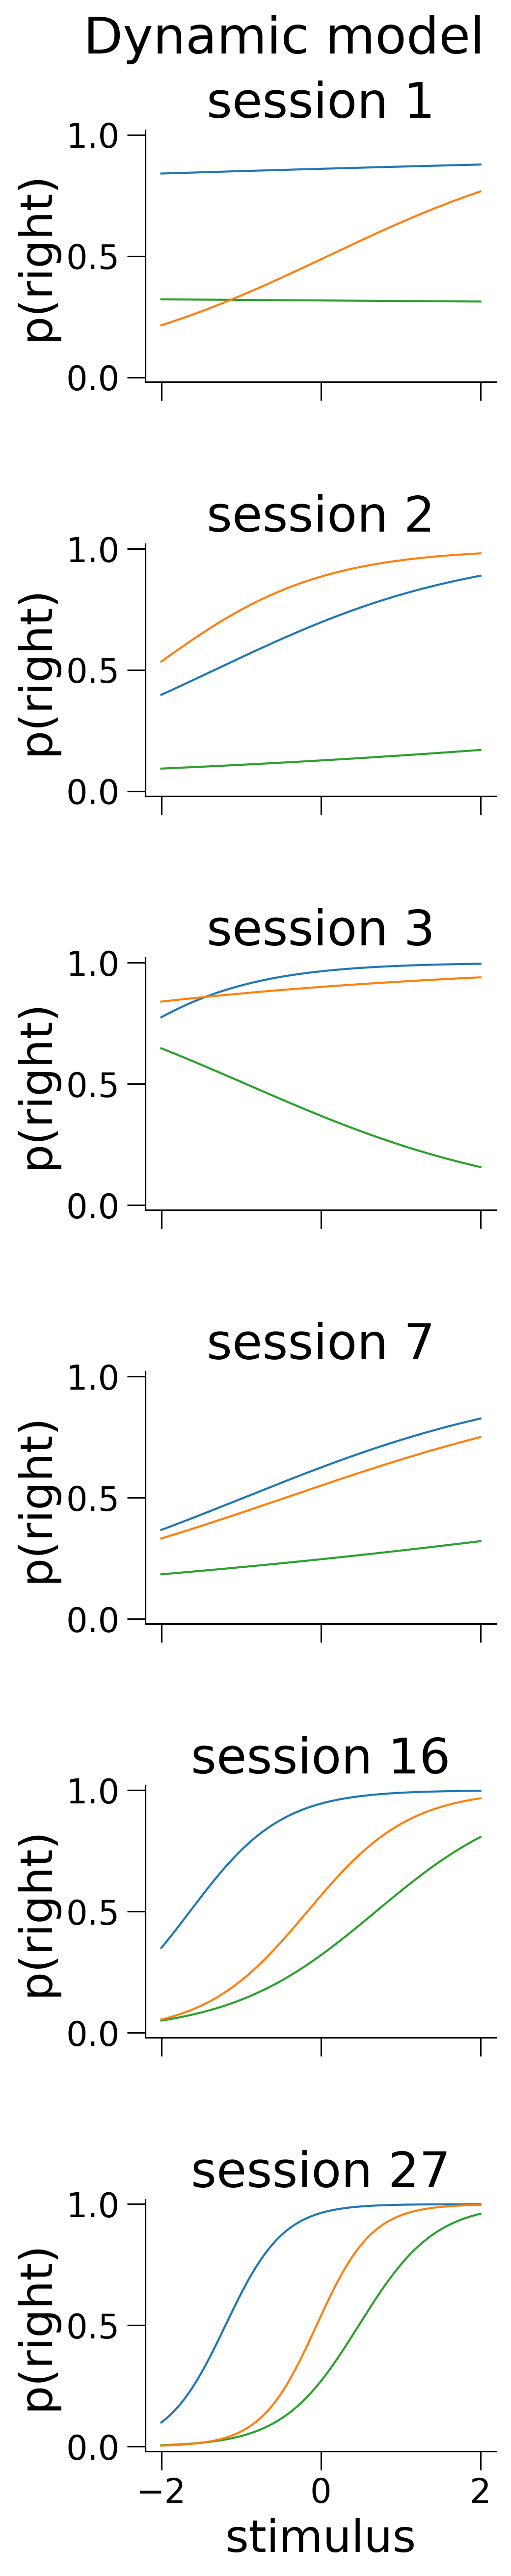

In [18]:
# plotting per-state psychometrics for example sessions
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(5,len(sessionsInterest)*3), dpi=300, sharex=True)
fig.tight_layout(pad=3.5)
fig.suptitle('Dynamic model', size=25, y=0.99)
for s in range(0,len(sessionsInterest)):
    plotting_psychometric(w=reshaped_best_W_dynamic, sessInd=sessInd, session=sessionsInterest[s], axes=axes[s], colorsStates=colorsStates, signedStimulus=True, linewidth=1)
    axes[s].set_title(f'session {sessionsInterest[s]+1}', size=24)
    axes[s].spines[['right', 'top']].set_visible(False)
    axes[s].spines[['left', 'bottom']].set_linewidth(0.75)
    axes[s].get_legend().remove()
    axes[s].set_ylabel('p(right)', size=22)
    axes[s].set_xlabel('')  
    axes[s].set_ylim(-0.02,1.02)
    axes[s].xaxis.set_tick_params(width=0.75)
    axes[s].yaxis.set_tick_params(width=0.75)
axes[-1].set_xlabel('stimulus', size=22)  
plt.savefig(f'../figures/psychometrics_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)



# Figure 3E

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


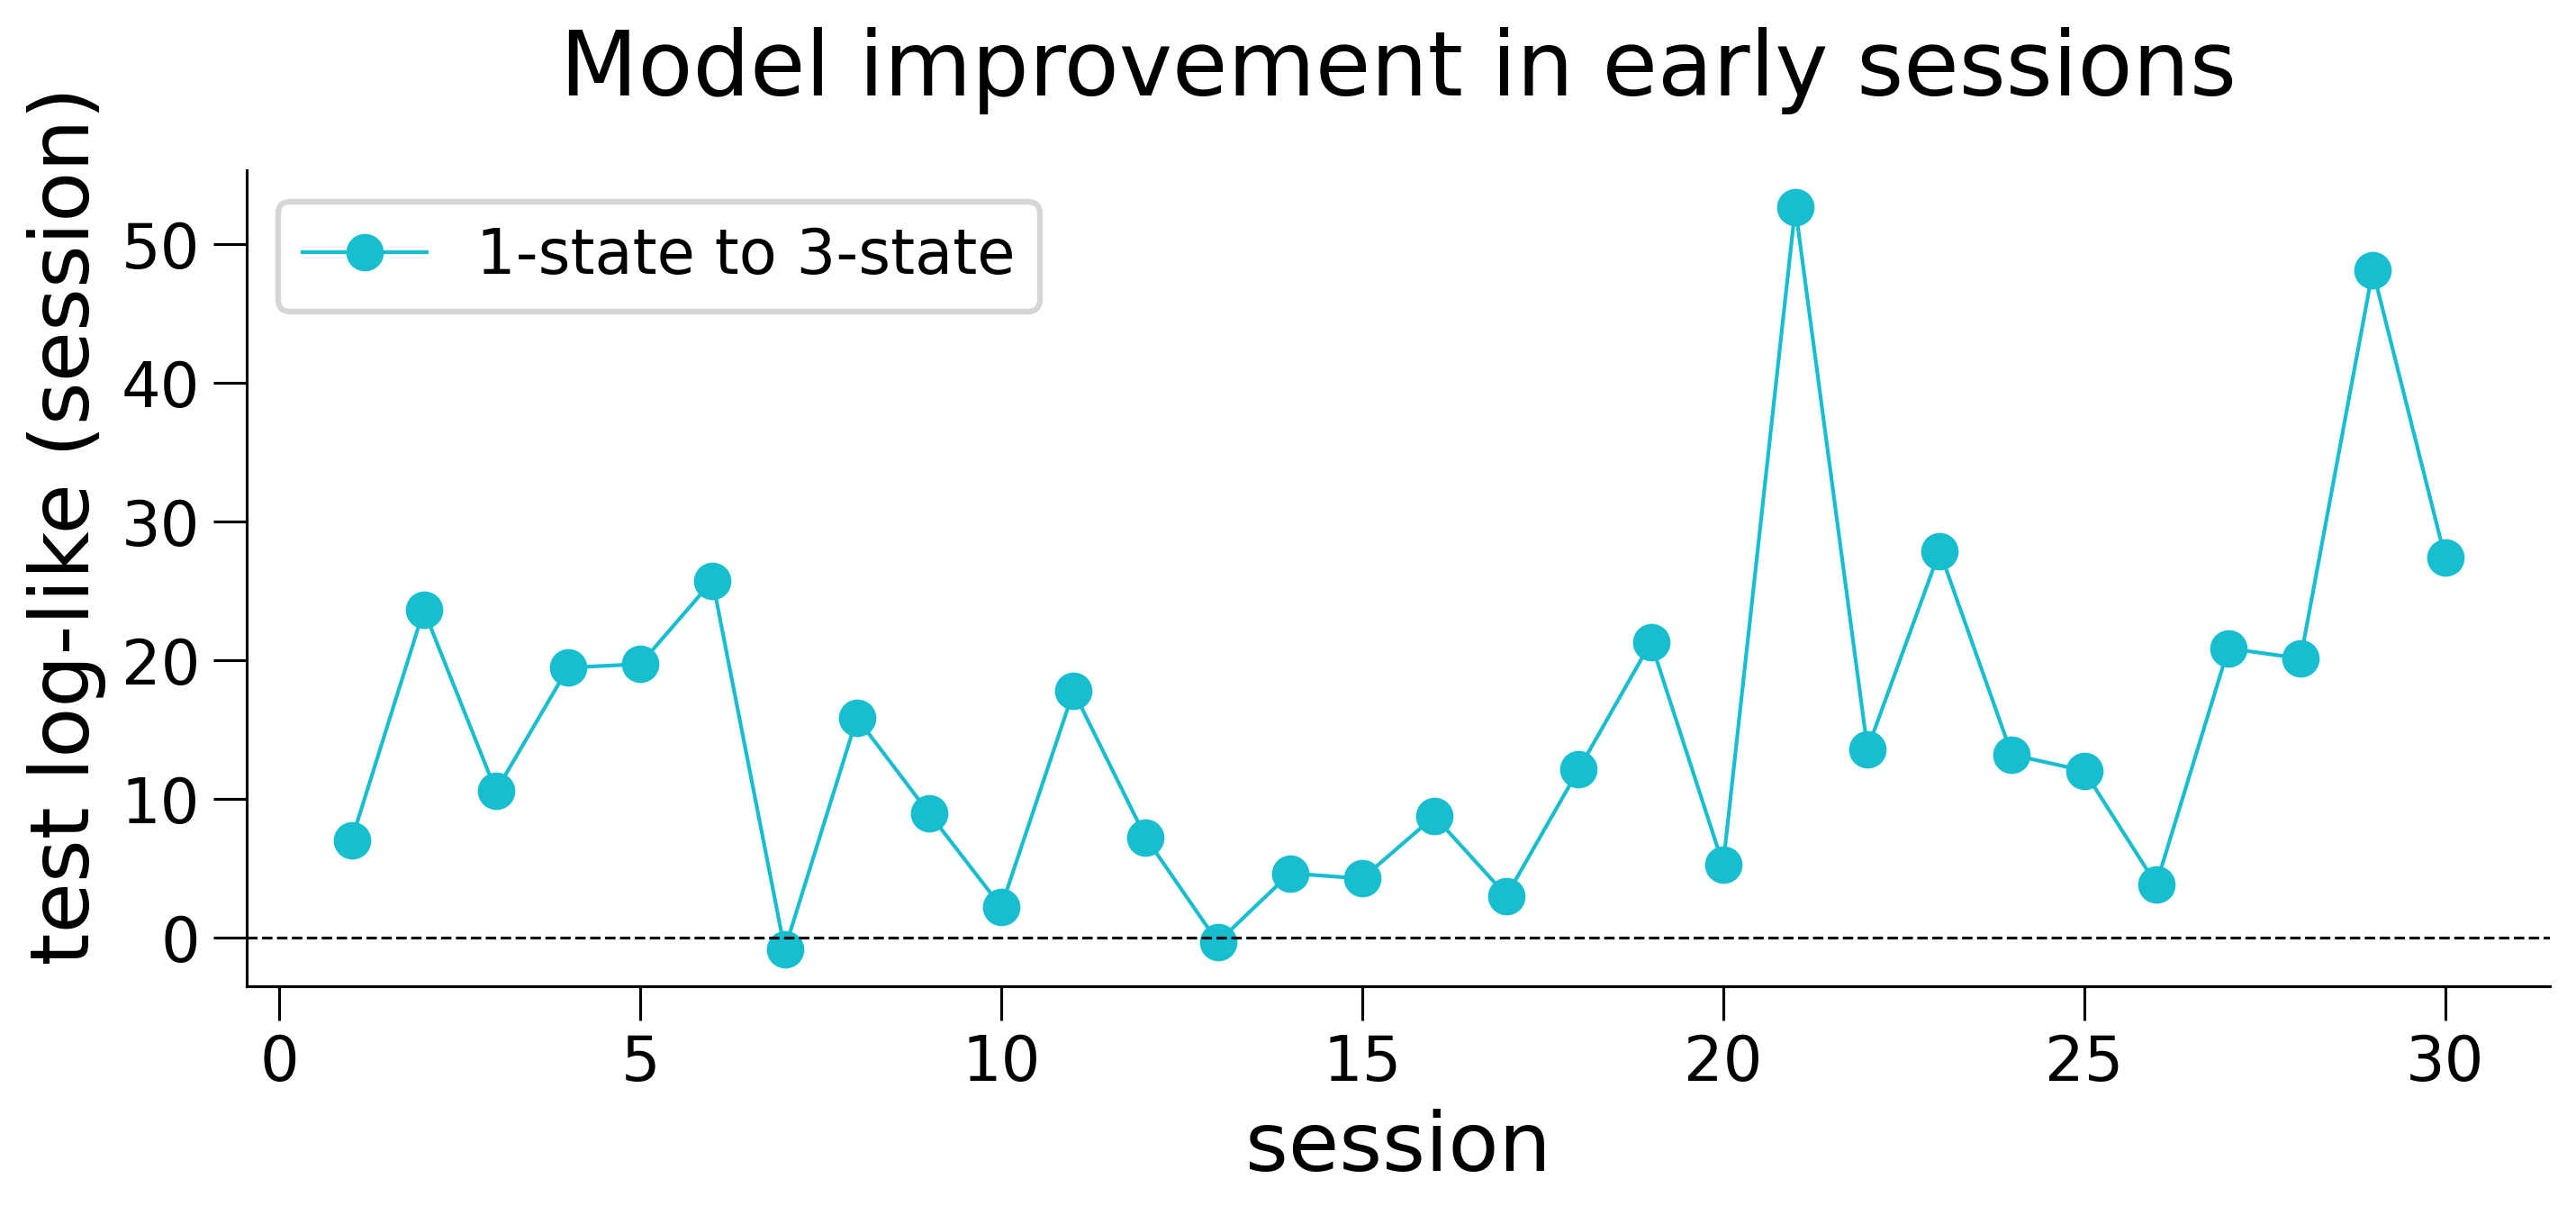

In [19]:
# Model performance for 1 state vs 3 state as a function of session number
sessInterest = 30 # number of session to look at (training period)
testLl_sessions = np.zeros((3, sessInterest, splitFolds))
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) # NOT LOOKING AT FULL DATASET
N = x.shape[0]
presentTrain, presentTest = split_data(N, sessInd, folds=splitFolds, blocks=10, random_state=1)

for fold in range(0, splitFolds):
    data3 = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_3-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
    data1 = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_1-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
    testLl_sessions[2,:,fold] =  data3['testLlSessions'][bestAlphaInd,0:sessInterest]
    testLl_sessions[0,:,fold] = data1['testLlSessions'][bestSigmaInd,0:sessInterest]

fig, axes = plt.subplots(1, figsize = (11,4), dpi=300)
avgTestLl = np.mean(testLl_sessions, axis=2)
axes.plot(range(1,sessInterest+1), (avgTestLl[2]-avgTestLl[0]) * avg_session_length, '-o', color = colormap[2], label='1-state to 3-state', linewidth=1)
axes.set_xlabel('session', size=22)
axes.set_ylabel('    test log-like (session)', size=22)
axes.legend(loc='upper left')
axes.axhline(0, color='black', linestyle='dashed', linewidth=0.75)
axes.set_title('Model improvement in early sessions', size=24, pad=20)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_xticks(range(0,sessInterest+1,5),range(0,sessInterest+1,5))
plt.savefig(f'../figures/Test_Log-Like_1vs3states_early_sessions.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 3F

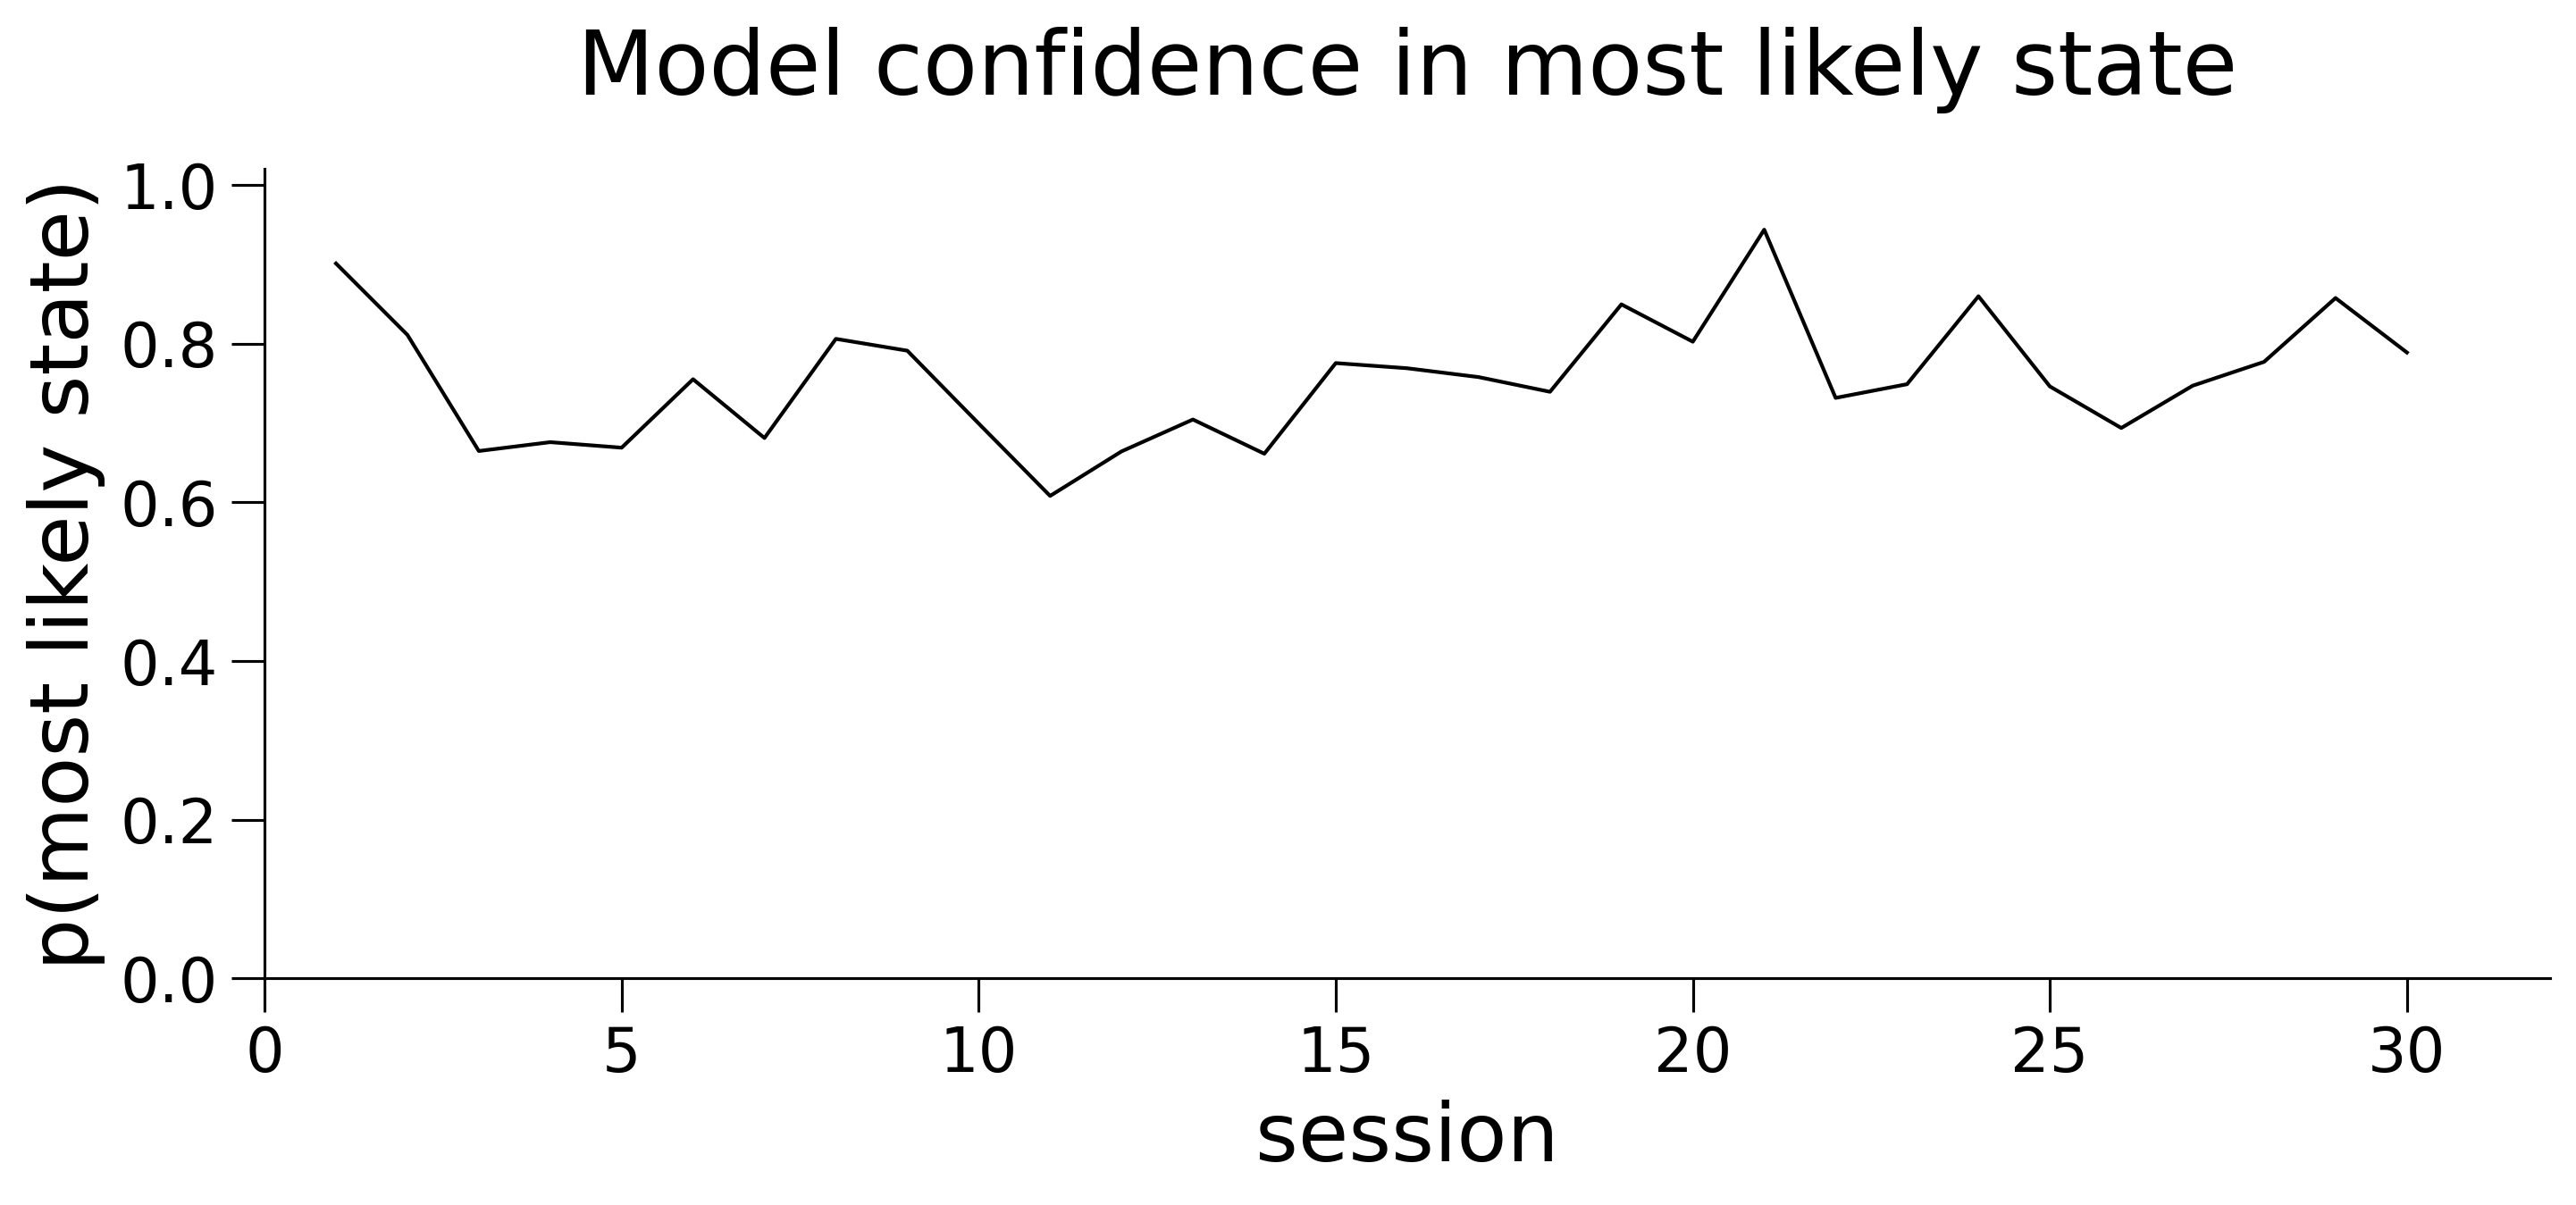

In [20]:
# confidence of model in assigning the latent state
fig, axes = plt.subplots(1, figsize=(11,4), dpi=300)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.set_xlabel('session', size=22)
axes.set_ylabel('p(most likely state)', size=22)
axes.set_ylim(0,1.02)
axes.set_xlim(0,sessInterest+2)
axes.set_title('Model confidence in most likely state', size=24, pad=20)
probMaxSession = distribution_most_likely_state(gamma, sessInd[:sessInterest+1], axes, linewidth=1)
axes.set_xticks(range(0,31,5),range(0,31,5))
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
plt.savefig(f'../figures/latent_most-likely-state_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)

# Supplemental Figure 2A

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


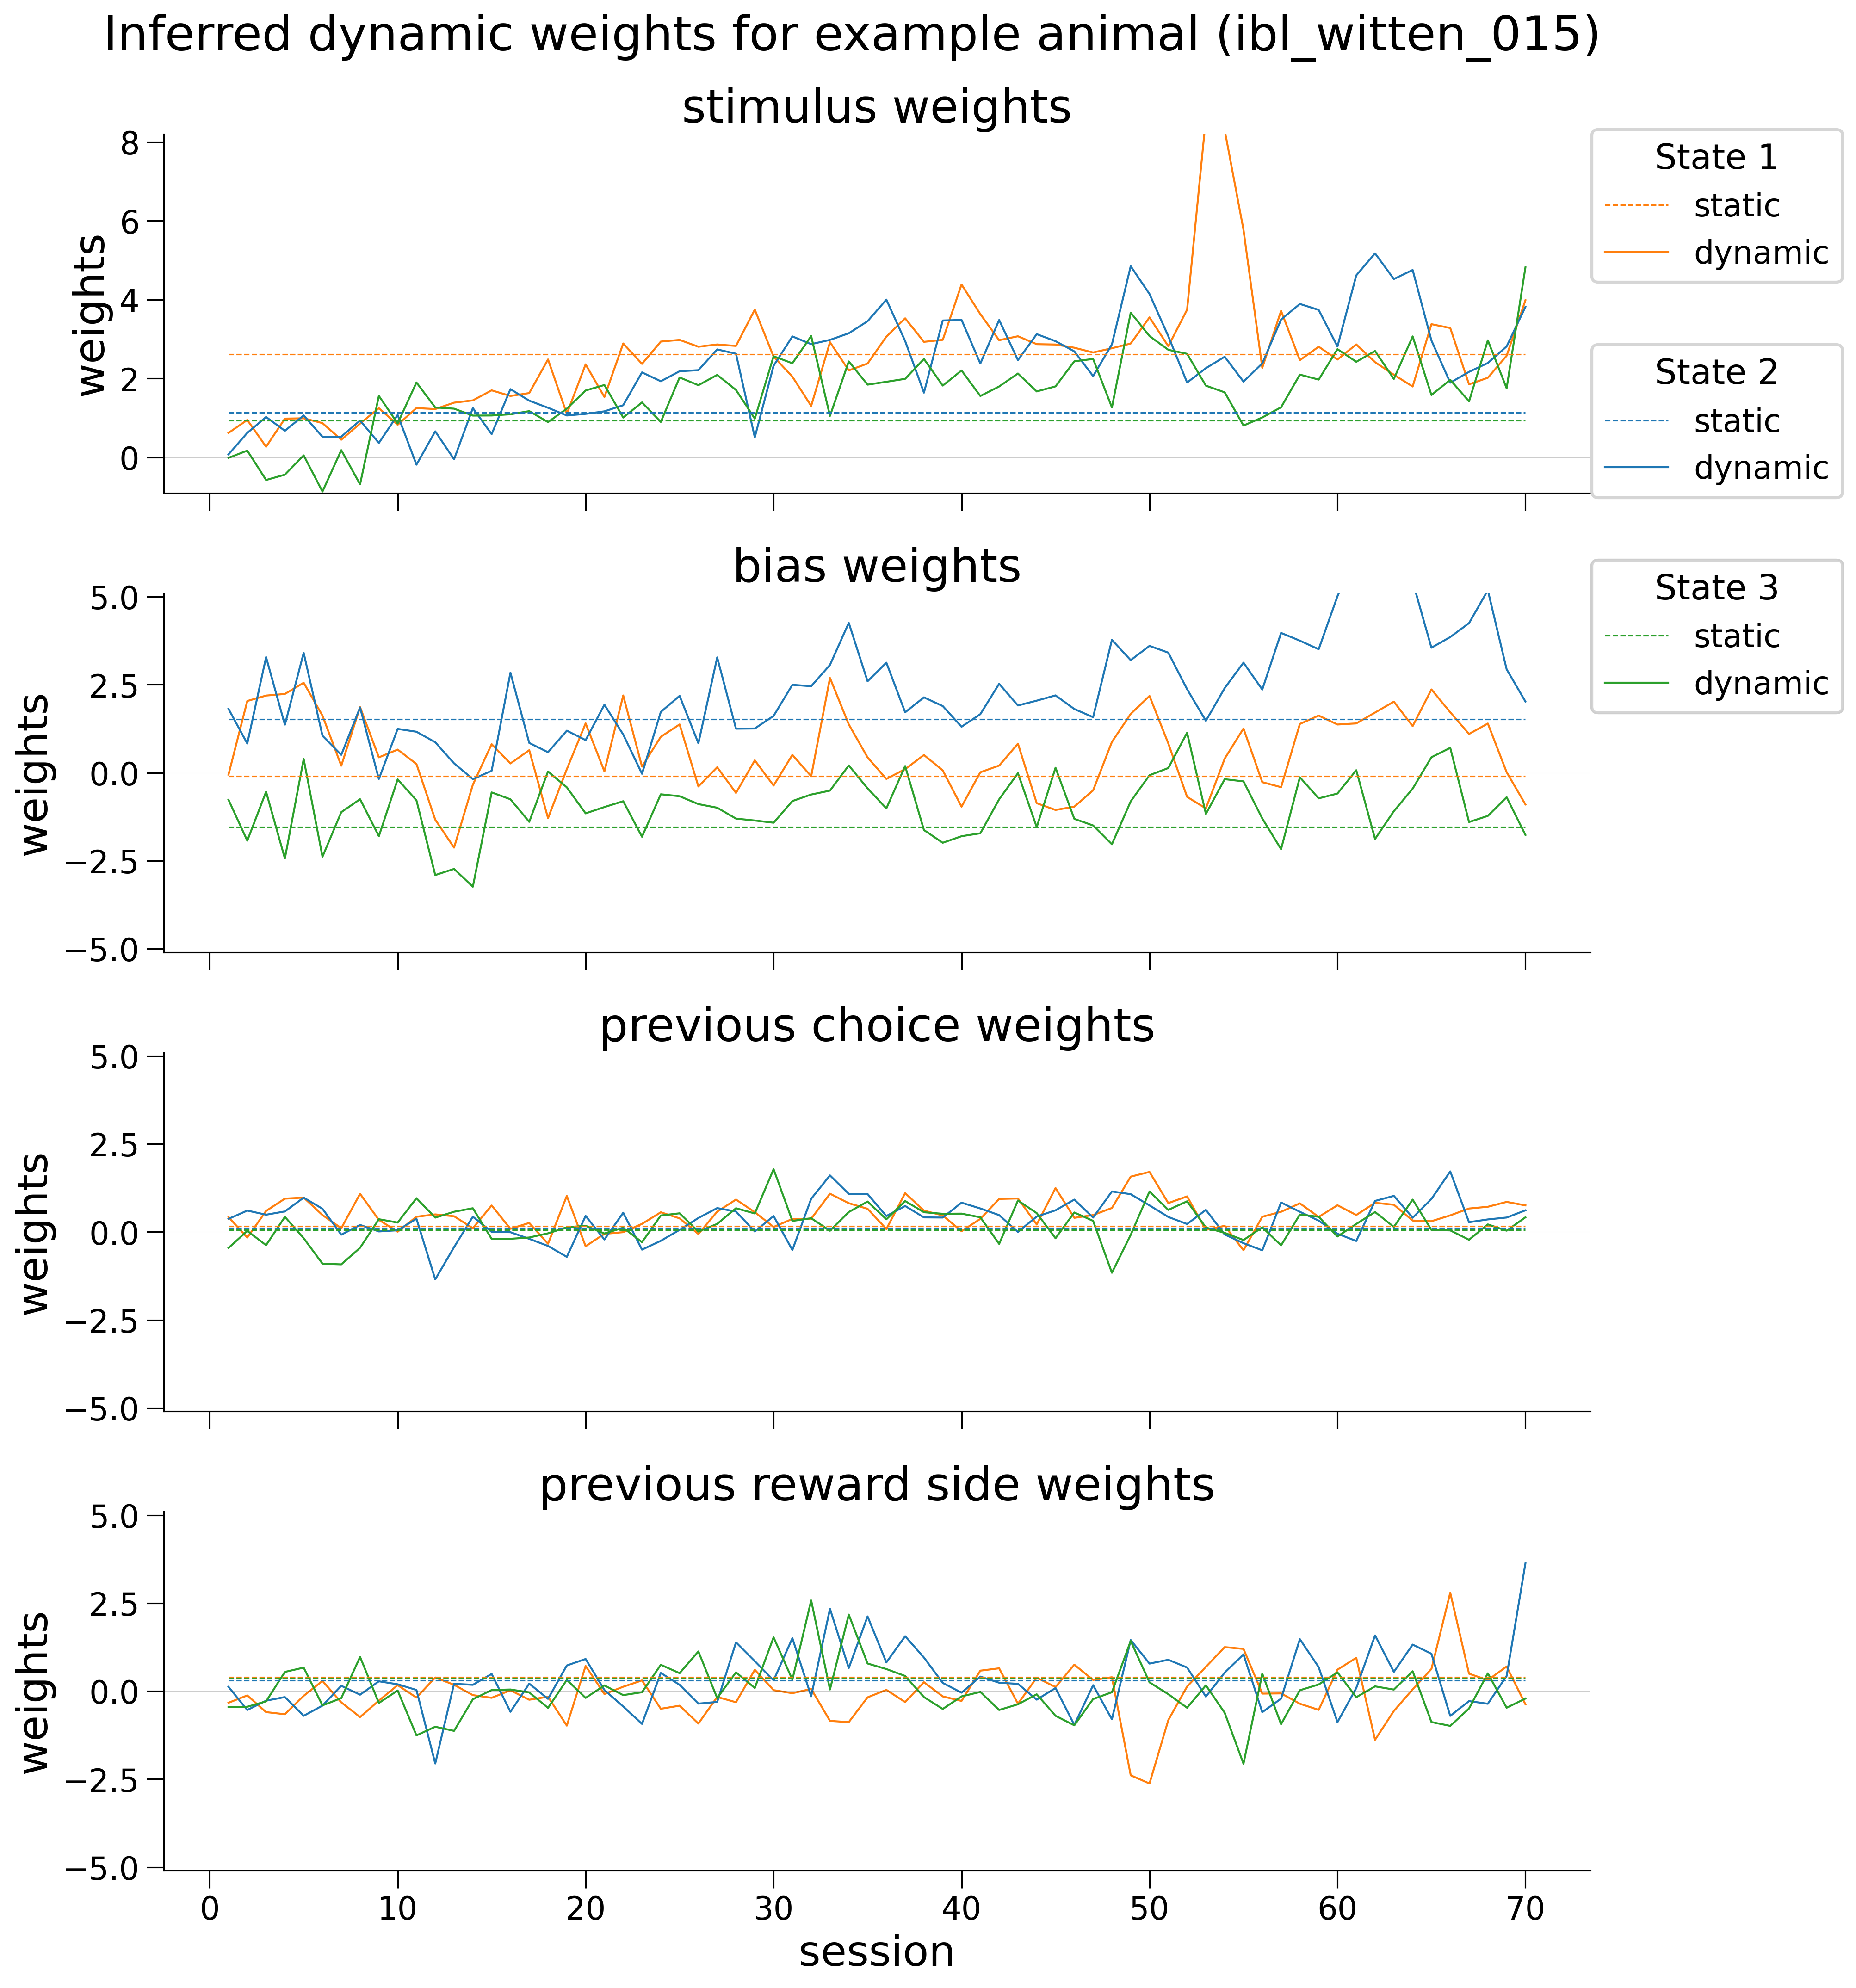

In [21]:
# plotting inferred weights for best fitting 3-state dynamic model for all features used
bestSigmaInd = 8
sns.set_context("talk")
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward side'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
plotSess = len(sessInd)-1 
fig, axes = plt.subplots(4, 1,figsize=(12,14), sharex=True, dpi=300)
fig.tight_layout(pad=2)
yLim=[[-5.1,5.1],[-0.9,8.2],[-5.1,5.1],[-5.1,5.1]]
for d in range(0, 2):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='-', linewidth=0.25)
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),reshaped_best_W_static[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=0.75, alpha=1, linestyle='--', label='static', zorder=1)
        axes[d].plot(range(1,plotSess+1),reshaped_best_W_dynamic[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=1, alpha=1, linestyle='-', label='dynamic', zorder=0)
    axes[d].set_ylim(yLim[1-d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights', size=22)
    axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=24)
    axes[d].spines[['right', 'top']].set_visible(False)
    axes[d].spines[['left', 'bottom']].set_linewidth(0.75)
    axes[d].xaxis.set_tick_params(width=0.75)
    axes[d].yaxis.set_tick_params(width=0.75)

for d in range(2, D):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='-', linewidth=0.25)
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),reshaped_best_W_static[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=0.75, alpha=1, linestyle='--', label='   =0', zorder=1)
        axes[d].plot(range(1,plotSess+1),reshaped_best_W_dynamic[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=1, alpha=1, linestyle='-', label='   =1', zorder=0)
    axes[d].set_ylim(yLim[d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights', size=22)
    axes[d].set_title(f'{myFeatures[D%2][d]} weights', size=24)
    axes[d].spines[['right', 'top']].set_visible(False)
    axes[d].spines[['left', 'bottom']].set_linewidth(0.75)
    axes[d].xaxis.set_tick_params(width=0.75)
    axes[d].yaxis.set_tick_params(width=0.75)
    
lines = axes[0].get_lines()
include = [1,2]
legend1 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.8), title = "State 1")
include = [3,4]
legend2 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.2), title = "State 2")
include = [5,6]
legend3 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, -0.4), title = "State 3")
axes[0].add_artist(legend1)
axes[0].add_artist(legend2)
axes[0].add_artist(legend3)
axes[-1].set_xlabel('session', size=22)
fig.suptitle('Inferred dynamic weights for example animal (ibl_witten_015)', size=25, y=1.02)
plt.savefig(f'../figures/weights_allFeatures_sigma=1_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)